# CRiCD4 Full dataset - QC analysis

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import yaml
import glob
import scanpy as sc
import anndata as ad
import rapids_singlecell as rsc
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# Configure matplotlib for Illustrator-compatible PDFs
mpl.rcParams['pdf.fonttype'] = 42  # Embed fonts as TrueType
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.dpi'] = 300  # or 150, 200, etc.
plt.rcParams['savefig.dpi'] = 300

# Increase all font sizes
plt.rcParams['font.size'] = 16  # Base font size
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 15

from preprocess import _convert_oak_path
import qc_plots
from sgrna_assignment import sgrna_assignments2adata

In [3]:
import psutil

# Get system memory information
mem_info = psutil.virtual_memory()

# Display total, available, and used memory in GB
print(f"Total memory: {mem_info.total / (1024**3):.2f} GB")
print(f"Available memory: {mem_info.available / (1024**3):.2f} GB")
print(f"Used memory: {mem_info.used / (1024**3):.2f} GB")
print(f"Memory percentage used: {mem_info.percent}%")

Total memory: 995.52 GB
Available memory: 614.17 GB
Used memory: 374.18 GB
Memory percentage used: 38.3%


In [4]:
PLOTDIR = f'./results/'
sc.settings.figdir = PLOTDIR
os.makedirs(PLOTDIR, exist_ok=True)

# Read figure palettes
with open('../../metadata/figure_palettes.yaml', 'r') as f:
    palettes = yaml.safe_load(f)


def save_plot(pl_name, plot_dir = None):
    if plot_dir is None:
        plot_dir = PLOTDIR
    plt.savefig(f'{plot_dir}/{pl_name}.pdf');
    plt.savefig(f'{plot_dir}/{pl_name}.png');

Configuration

In [5]:
# Read config
config_file = '../../metadata/experiments_config.yaml'
with open(config_file, 'r') as f:
    config = yaml.safe_load(f)

sgrna_library_metadata = pd.read_csv('../../metadata/sgRNA_library_curated.csv', index_col=0)

In [6]:
sgrna_library_metadata.sgrna_id.nunique()

27272

## Summary of QC metrics

In [7]:
experiment_list = ['CD4iR2_Psomagen', 'CD4iR1_Psomagen']
all_qc_summary_list = []
all_count_perturbs_list = []

for experiment_name in experiment_list:
    exp_config = config[experiment_name]
    datadir = _convert_oak_path(exp_config['datadir'])
    qc_summary = pd.read_csv(f'{datadir}/QC_summary_stats.csv', index_col=0)
    count_perturbs = pd.read_csv(f'{datadir}/perturbation_counts.csv', index_col=0)
    qc_summary['experiment'] = experiment_name
    count_perturbs['experiment'] = experiment_name
    all_qc_summary_list.append(qc_summary)
    all_count_perturbs_list.append(count_perturbs)

all_qc_summary = pd.concat(all_qc_summary_list, axis=0)
all_count_perturbs = pd.concat(all_count_perturbs_list, axis=0)

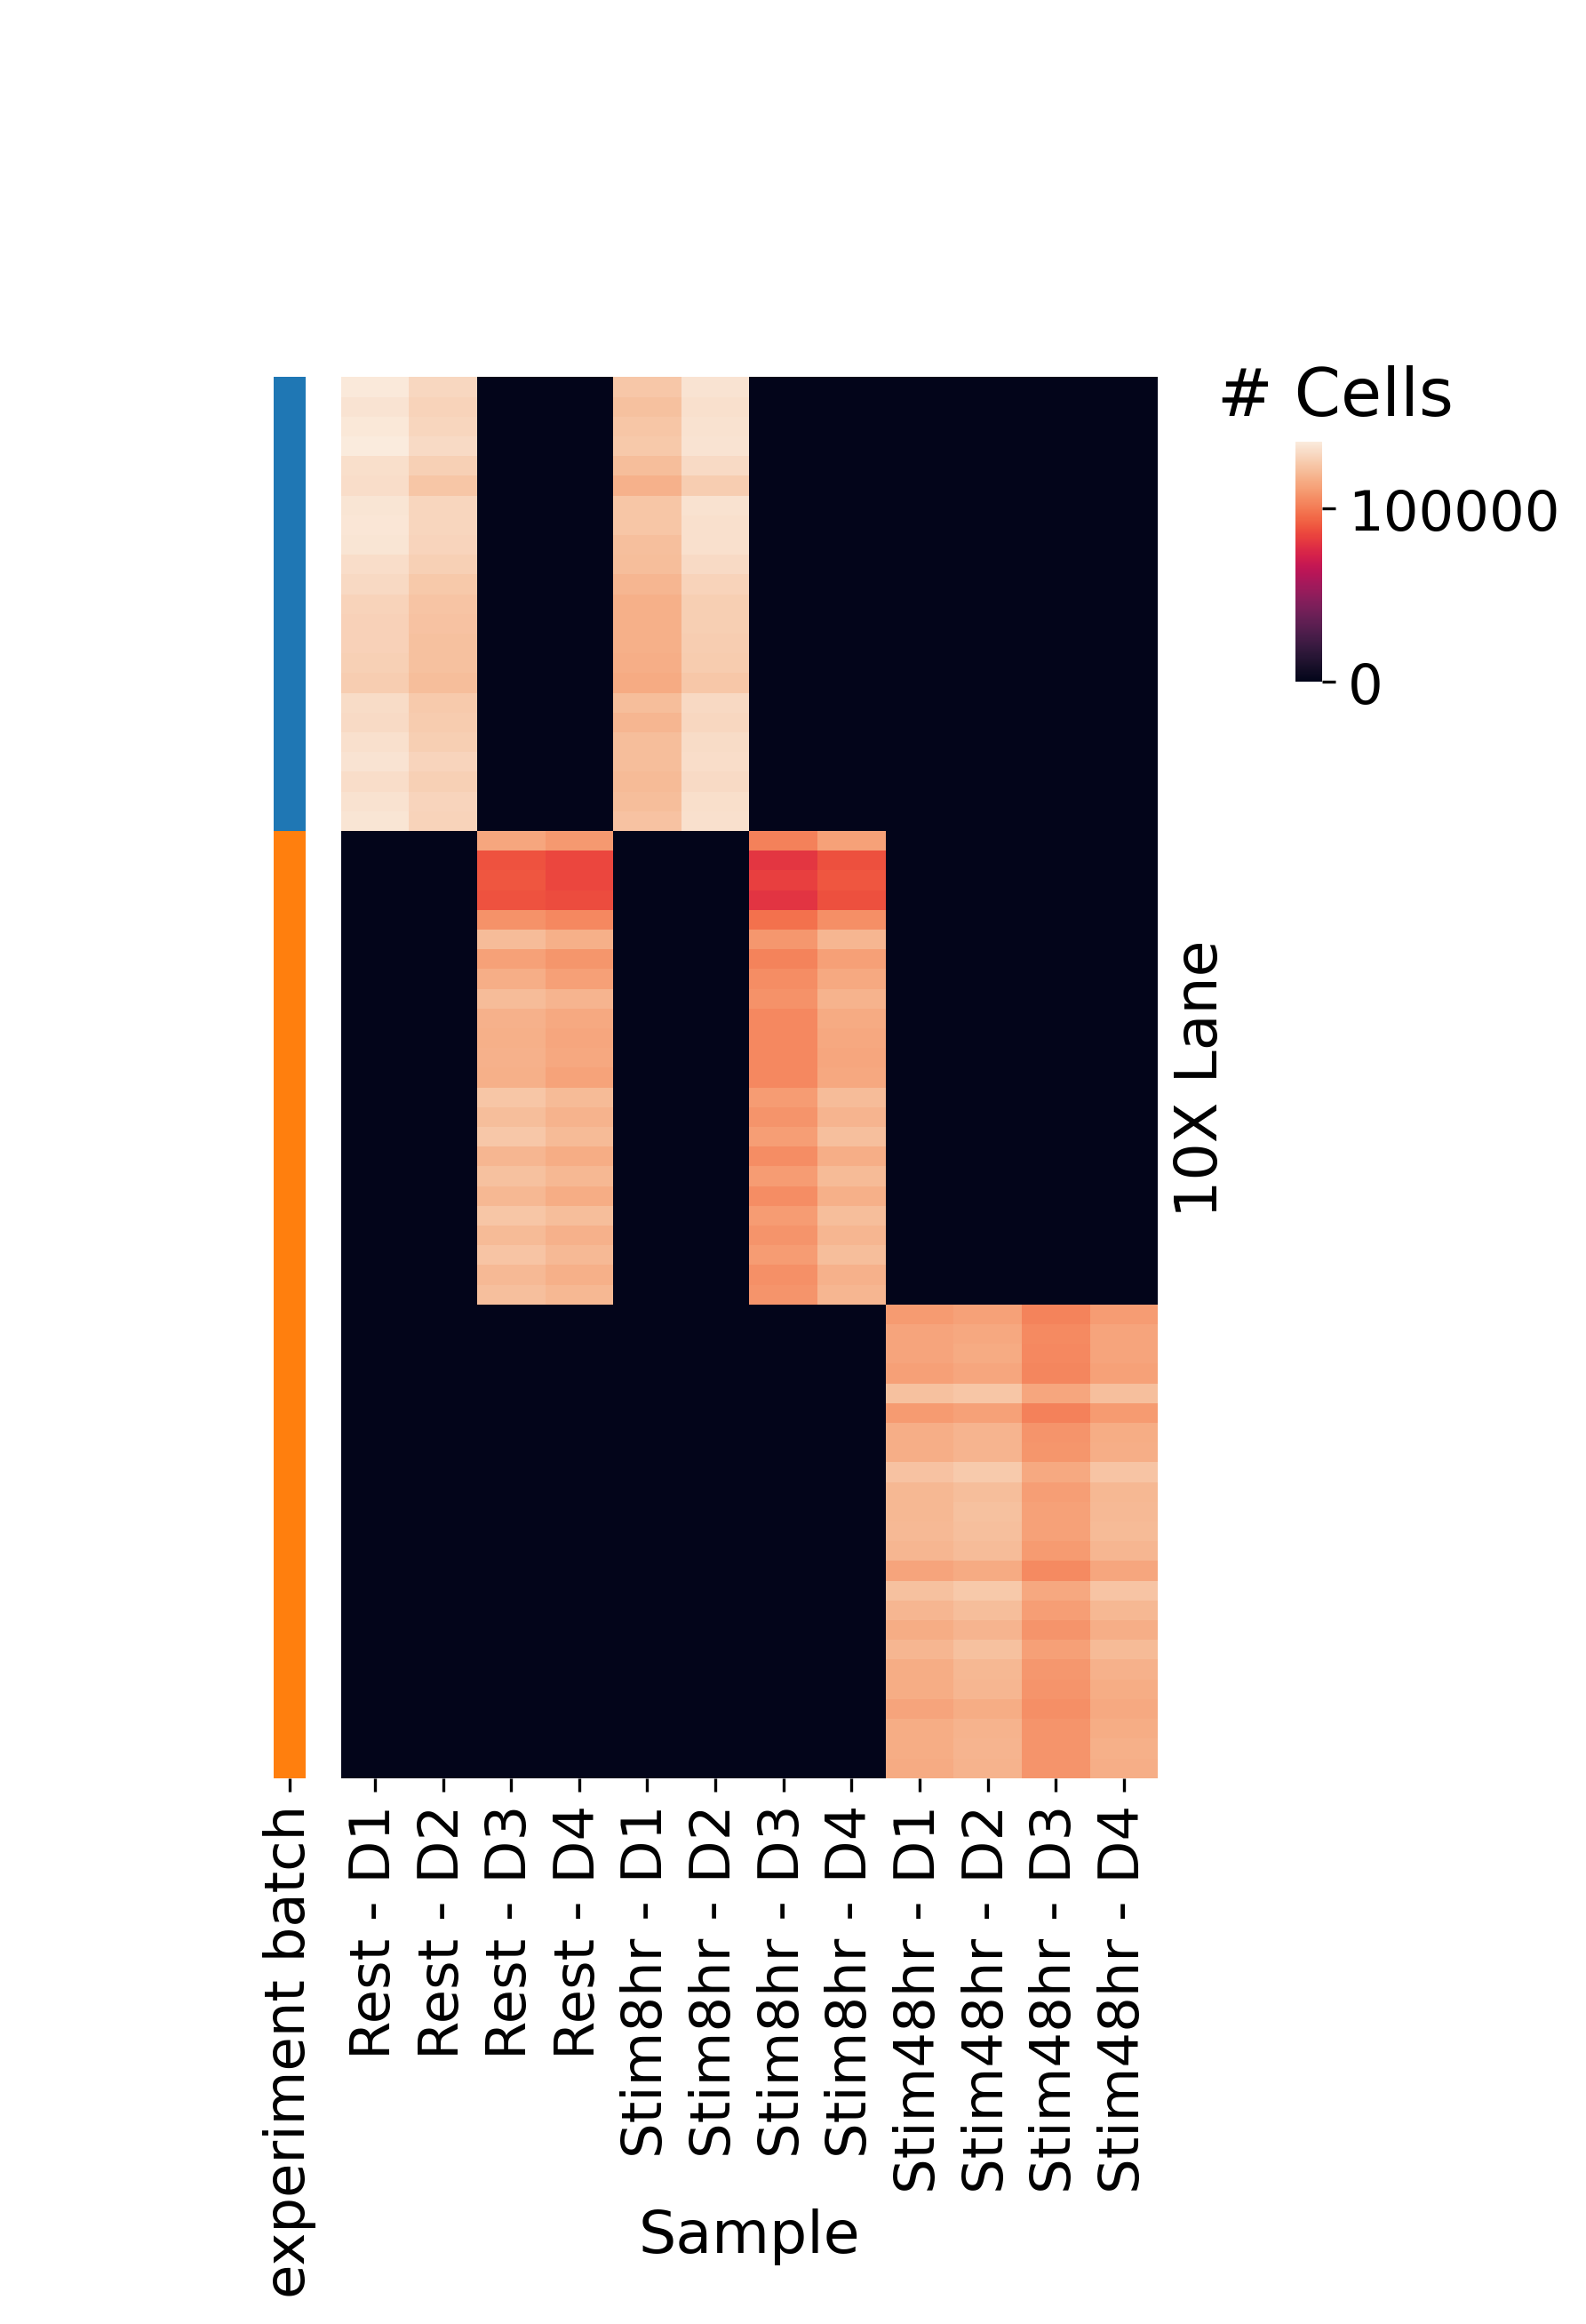

In [25]:
all_qc_summary['donor_id'] = all_qc_summary['library_id'].str.split('_').str[2]
all_qc_summary['culture_condition'] = all_qc_summary['library_id'].str.split('_').str[3]
all_qc_summary['experiment batch'] = all_qc_summary['library_id'].str.split('_').str[1]
all_qc_summary['sample_id'] = all_qc_summary['culture_condition'].astype(str) + ' - ' + all_qc_summary['donor_id'].astype(str)

# Create custom sort order for conditions
condition_order = ['Rest', 'Stim8hr', 'Stim48hr']
all_qc_summary['culture_condition'] = pd.Categorical(all_qc_summary['culture_condition'], categories=condition_order, ordered=True)

# Sort by culture_condition and sample_id
all_qc_summary['sample_id'] = pd.Categorical(all_qc_summary['sample_id'], 
    categories=[f"{cond} - {donor}" for cond in condition_order 
               for donor in sorted(all_qc_summary['donor_id'].unique())],
    ordered=True)
all_qc_summary = all_qc_summary.sort_values(['culture_condition', 'sample_id'])

design_mat = all_qc_summary.pivot(columns='sample_id', index='lane_id', values='n_cells').fillna(0)
# Create row annotation dataframe with color mapping
row_annot = pd.DataFrame(all_qc_summary[['lane_id', 'experiment batch']].drop_duplicates().set_index('lane_id')['experiment batch'])
color_map = {
    'R1': '#1f77b4',  # Blue
    'R2': '#ff7f0e'   # Orange
}
row_colors = row_annot['experiment batch'].map(color_map)
g = sns.clustermap(design_mat,
                   row_colors=row_colors, 
                   xticklabels=True,
                   yticklabels=False,
                   row_cluster=False,
                   col_cluster=False,
                   figsize=(5,9)
                )

# Add title and rotate colorbar
g.ax_cbar.set_title('# Cells', y=1.02, x=1.5)
g.ax_cbar.set_position([1, 0.7, 0.02, 0.1])  # [x, y, width, height]
# g.ax_cbar.set_title('', y=1.02)  # Remove old title
g.cbar_pos = (0.95, 0.8, 0.02, 0.1)  # Match position
g.ax_cbar.set_ylabel('', rotation=90)

# Add axis labels
g.ax_heatmap.set_xlabel('Sample')
g.ax_heatmap.set_ylabel('10X Lane')

# Save figures with tight layout
plt.savefig(PLOTDIR + '/design_heatmap.png', bbox_inches='tight')
plt.savefig(PLOTDIR + '/design_heatmap.pdf', bbox_inches='tight')

In [45]:
all_qc_summary.value_counts('library_id')

library_id
CD4i_R2_D3_Stim48hr_CD4i_R2_Ultima    24
CD4i_R2_D3_Rest_CD4i_R2_Ultima        24
CD4i_R2_D2_Stim48hr_CD4i_R2_Ultima    24
CD4i_R2_D1_Stim48hr_CD4i_R2_Ultima    24
CD4i_R2_D3_Stim8hr_CD4i_R2_Ultima     24
CD4i_R2_D4_Rest_CD4i_R2_Ultima        24
CD4i_R2_D4_Stim48hr_CD4i_R2_Ultima    24
CD4i_R2_D4_Stim8hr_CD4i_R2_Ultima     24
CD4i_R1_D2_Stim8hr_CD4i_R1_Ultima     23
CD4i_R1_D2_Rest_CD4i_R1_Ultima        23
CD4i_R1_D1_Stim8hr_CD4i_R1_Ultima     23
CD4i_R1_D1_Rest_CD4i_R1_Ultima        23
Name: count, dtype: int64

In [29]:
all_qc_summary.groupby('culture_condition')[['mean_total_counts', 'mean_n_genes']].mean()

,mean_total_counts,mean_n_genes
culture_condition,,
Rest,10840.101951,3907.326435
Stim8hr,14977.440665,4554.620458
Stim48hr,13373.491531,4425.630582


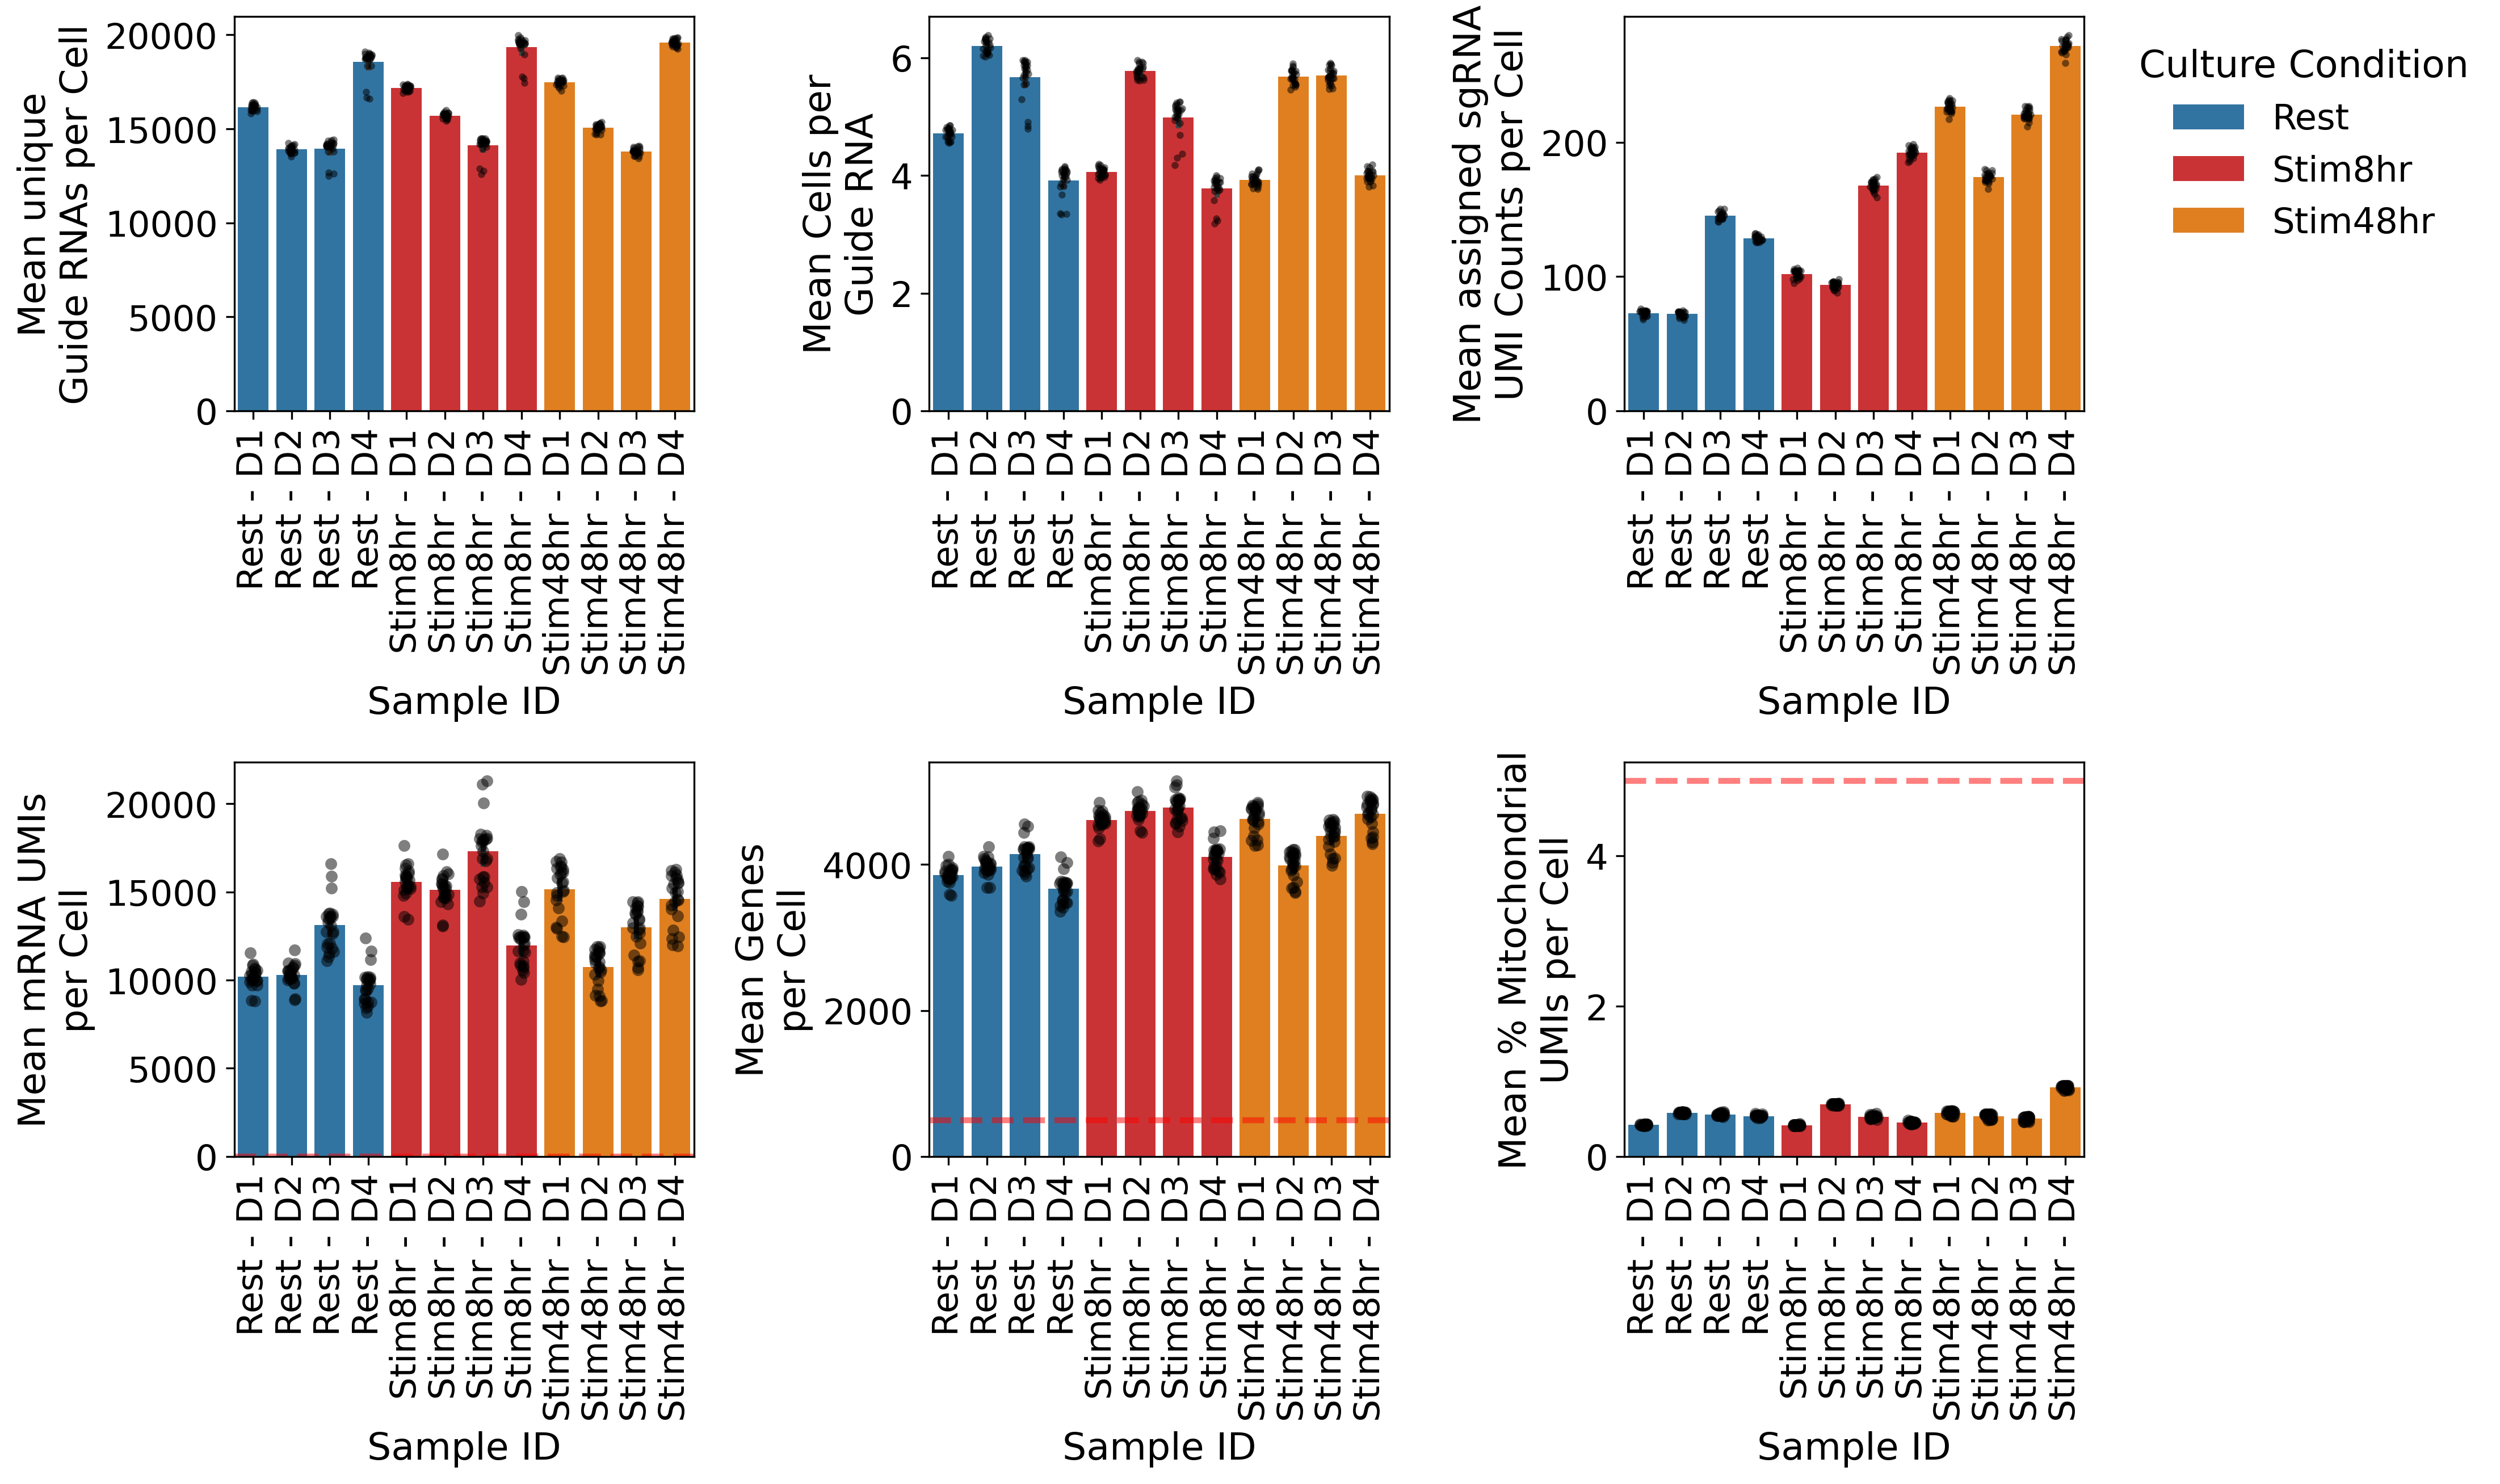

In [47]:
pl_cols = ['n_unique_guides',
       'mean_cells_x_guide','mean_top_guide_UMI_counts'
       ]

# Define better y-axis labels
y_labels = {
    'n_unique_guides': 'Mean unique\nGuide RNAs per Cell',
    # 'n_unique_perturbed_genes': 'Number of Unique\nPerturbed Genes',
    'mean_cells_x_guide': 'Mean Cells per\nGuide RNA',
    'mean_top_guide_UMI_counts': 'Mean assigned sgRNA\nUMI Counts per Cell' 
}

all_qc_summary['donor_id'] = all_qc_summary['library_id'].str.split('_').str[2]
all_qc_summary['culture_condition'] = all_qc_summary['library_id'].str.split('_').str[3]
all_qc_summary['sample_id'] = all_qc_summary['culture_condition'].astype(str) + ' - ' + all_qc_summary['donor_id'].astype(str)

# Create ordered list of sample_ids
sample_id_order = []
for condition in ['Rest', 'Stim8hr', 'Stim48hr']:
    for donor in sorted(all_qc_summary['donor_id'].unique()):
        sample_id = f'{condition} - {donor}'
        if sample_id in all_qc_summary['sample_id'].values:
            sample_id_order.append(sample_id)

# Create figure with 2 rows
fig, axes = plt.subplots(2, 3, figsize=(15, 9))

# First row - perturbation metrics
for idx, col in enumerate(pl_cols):
    sns.barplot(data=all_qc_summary, x='sample_id', y=col, hue='culture_condition', 
                order=sample_id_order, ax=axes[0,idx], palette=palettes['culture_condition'])
    sns.stripplot(data=all_qc_summary, x='sample_id', y=col, color='black', 
                 size=3, alpha=0.5, order=sample_id_order,
                 legend=False, ax=axes[0,idx])
    
    axes[0,idx].set_xticklabels(axes[0,idx].get_xticklabels(), rotation=90)
    axes[0,idx].set_xlabel('Sample ID')
    axes[0,idx].set_ylabel(y_labels[col])
    
    # Only show legend on last plot
    if idx != 2:
        axes[0,idx].get_legend().remove()
    else:
        axes[0,idx].legend(bbox_to_anchor=(1.05, 1), loc='upper left', 
                        title='Culture Condition', frameon=False)

# Second row - QC metrics
pl_cols = ['mean_total_counts', 'mean_n_genes',
       'mean_pct_counts_mt', 
       ]

qc_thresholds = {
    'mean_total_counts':0,
    'mean_n_genes':500,
    'mean_pct_counts_mt':5,
}

y_labels = {
    'mean_total_counts': 'Mean mRNA UMIs\nper Cell',  
    'mean_n_genes': 'Mean Genes\nper Cell',  
    'mean_pct_counts_mt': 'Mean % Mitochondrial\nUMIs per Cell',  
}

for idx, col in enumerate(pl_cols):
    sns.barplot(data=all_qc_summary, x='sample_id', y=col, hue='culture_condition', 
                order=sample_id_order, ax=axes[1,idx], palette=palettes['culture_condition'])
    sns.stripplot(data=all_qc_summary, x='sample_id', y=col, color='black', 
                 size=5, alpha=0.5, order=sample_id_order,
                 legend=False, ax=axes[1,idx])
    
    # Add horizontal dotted line for QC threshold
    threshold = qc_thresholds[col]
    axes[1,idx].axhline(y=threshold, color='red', linestyle='--', alpha=0.5, 
                     label=f'QC threshold', linewidth=2.5)
    axes[1,idx].set_xticklabels(axes[1,idx].get_xticklabels(), rotation=90)
    axes[1,idx].set_xlabel('Sample ID')
    axes[1,idx].set_ylabel(y_labels[col])
    
    # Only show legend on last plot
    if idx != 3:
        axes[1,idx].get_legend().remove()
    else:
        axes[1,idx].legend(bbox_to_anchor=(1.05, 1), loc='upper left', 
                        title='Culture Condition', frameon=False)

plt.tight_layout()
plt.savefig(PLOTDIR + "QC_metrics.png")
plt.savefig(PLOTDIR + "QC_metrics.pdf")

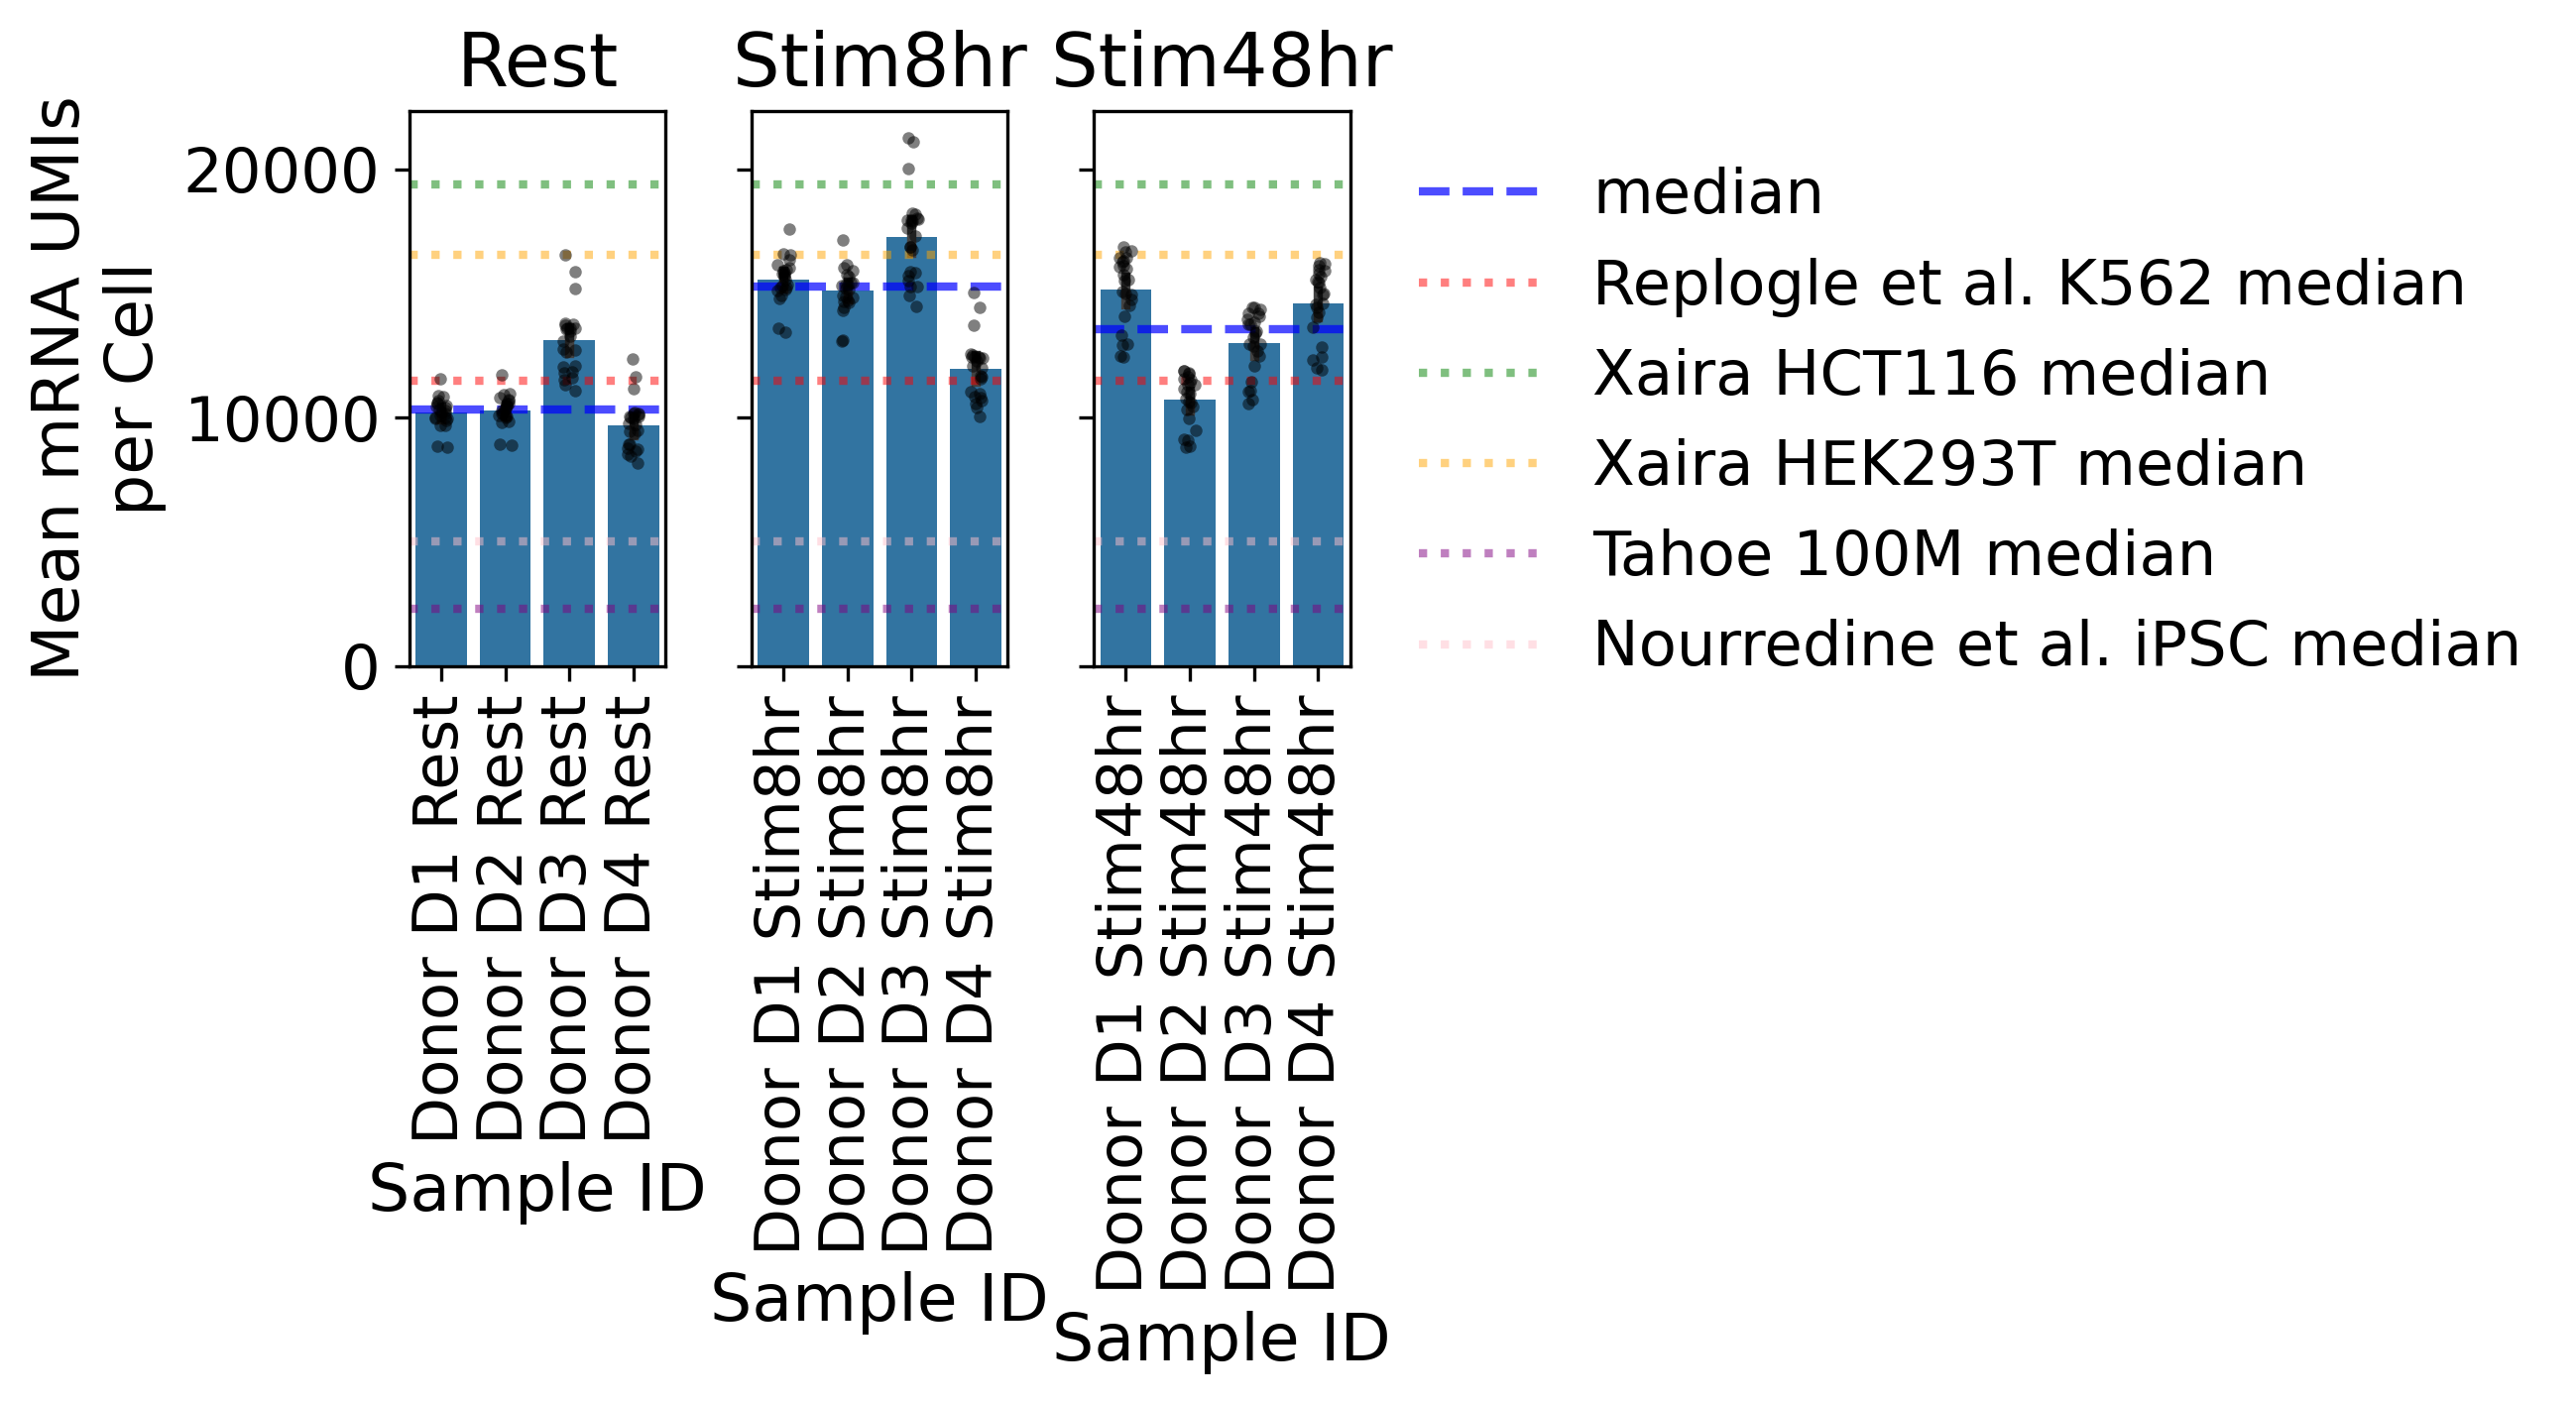

In [48]:
# Taken from Xaira biorxiv paper
comparison_medians = {
    'Replogle et al. K562': 11499,
    'Xaira HCT116': 19416, 
    'Xaira HEK293T': 16557,
    'Tahoe 100M': 2298,
    'Nourredine et al. iPSC': 5000
}

conditions_medians = all_qc_summary.groupby('culture_condition')['mean_total_counts'].median()

# Define better y-axis labels
y_labels = {
    'mean_total_counts': 'Mean mRNA UMIs\nper Cell'  # Higher is better
}

all_qc_summary['donor_id'] = all_qc_summary['library_id'].str.split('_').str[2]
all_qc_summary['culture_condition'] = all_qc_summary['library_id'].str.split('_').str[3]
all_qc_summary['sample_id'] = 'Donor ' + all_qc_summary['donor_id'] + ' ' + all_qc_summary['culture_condition']

# Create ordered list of sample_ids per condition
sample_id_orders = {}
for condition in ['Rest', 'Stim8hr', 'Stim48hr']:
    sample_id_orders[condition] = []
    for donor in sorted(all_qc_summary['donor_id'].unique()):
        sample_id = f'Donor {donor} {condition}'
        if sample_id in all_qc_summary['sample_id'].values:
            sample_id_orders[condition].append(sample_id)

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(9, 5), sharey=True)

for idx, condition in enumerate(['Rest', 'Stim8hr', 'Stim48hr']):
    # Filter data for this condition
    condition_data = all_qc_summary[all_qc_summary['culture_condition'] == condition]
    
    sns.barplot(data=condition_data, x='sample_id', y='mean_total_counts',
                order=sample_id_orders[condition], ax=axes[idx])
    sns.stripplot(data=condition_data, x='sample_id', y='mean_total_counts', color='black',
                 size=3, alpha=0.5, order=sample_id_orders[condition],
                 legend=False, ax=axes[idx])

    # Add horizontal line for condition median
    axes[idx].axhline(y=conditions_medians[condition], color='blue', linestyle='--', alpha=0.7,
                      label=f'median', linewidth=2)
    
    # Add lines for comparison datasets
    colors = ['red', 'green', 'orange', 'purple', 'pink']
    for (dataset, median), color in zip(comparison_medians.items(), colors):
        axes[idx].axhline(y=median, color=color, linestyle=':', alpha=0.5,
                         label=f'{dataset} median', linewidth=2)

    axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=90)
    axes[idx].set_xlabel('Sample ID')
    axes[idx].set_title(condition)
    
    if idx == 0:
        axes[idx].set_ylabel(y_labels['mean_total_counts'])
    else:
        axes[idx].set_ylabel('')
    
    # Only show legend on last subplot
    legend = axes[idx].get_legend()
    if idx != 2:
        if legend is not None:
            legend.remove()
    else:
        axes[idx].legend(bbox_to_anchor=(1.05, 1), loc='upper left',
                        frameon=False)

plt.tight_layout()

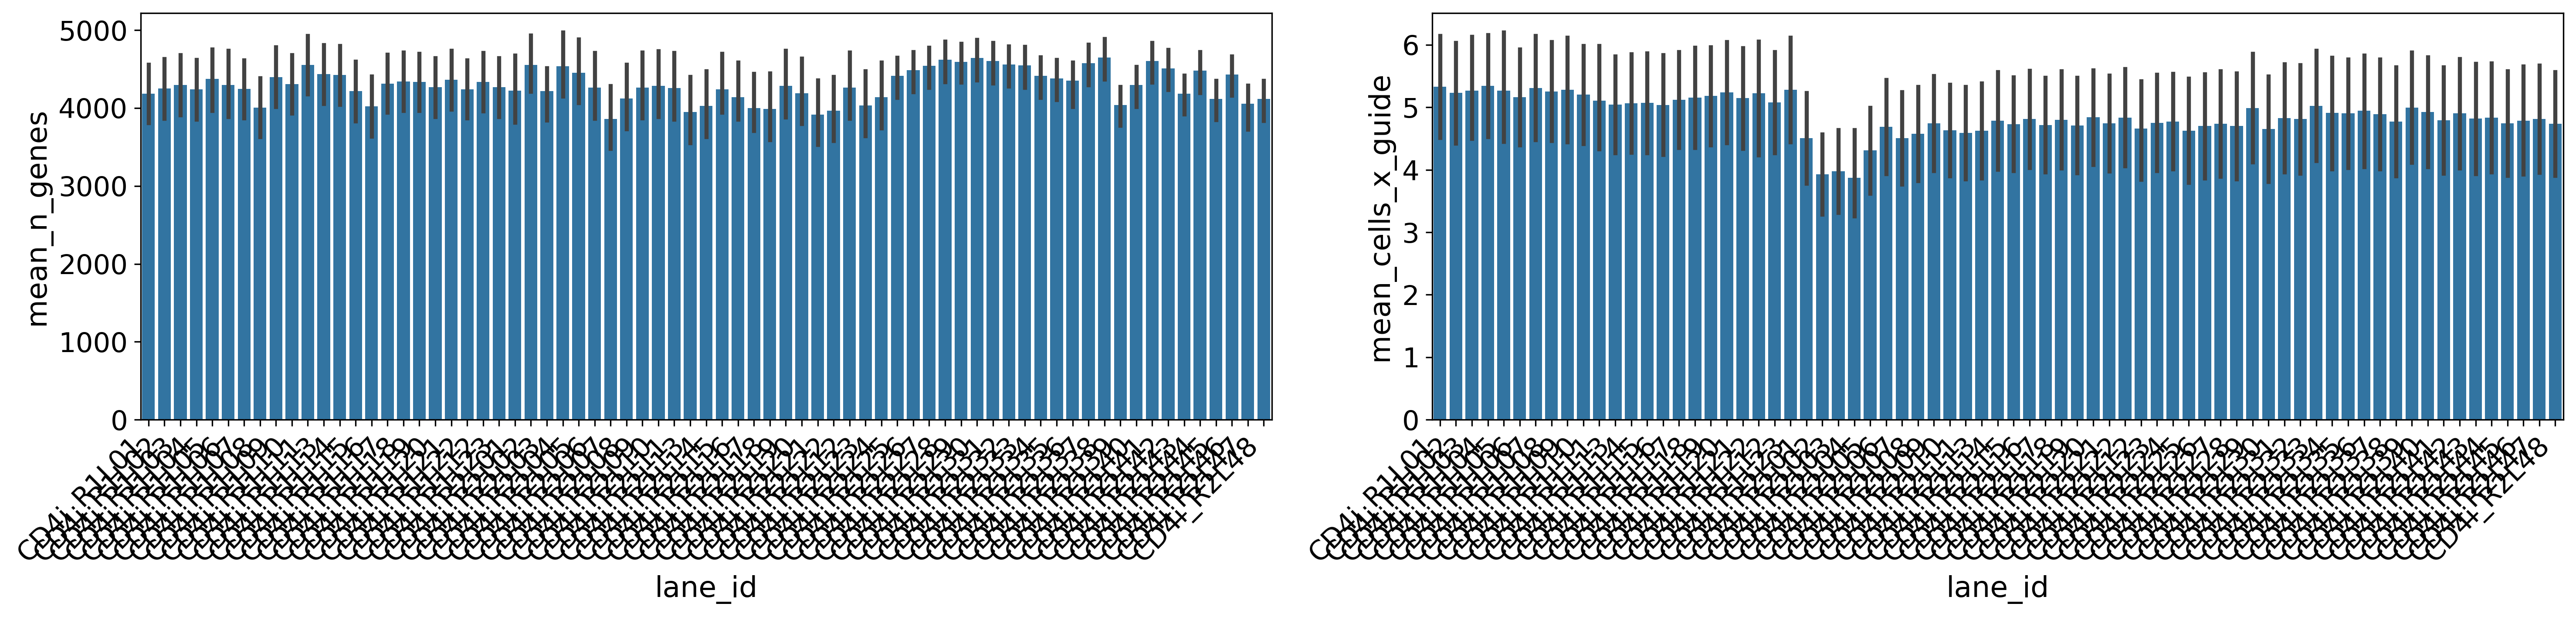

In [49]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 5))

sns.barplot(all_qc_summary, x='lane_id', y='mean_n_genes', ax=ax1)
# sns.stripplot(all_qc_summary, x='lane_id', y='mean_n_genes', ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

sns.barplot(all_qc_summary, x='lane_id', y='mean_cells_x_guide', ax=ax2)
# sns.stripplot(all_qc_summary, x='lane_id', y='mean_cells_x_guide', ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()

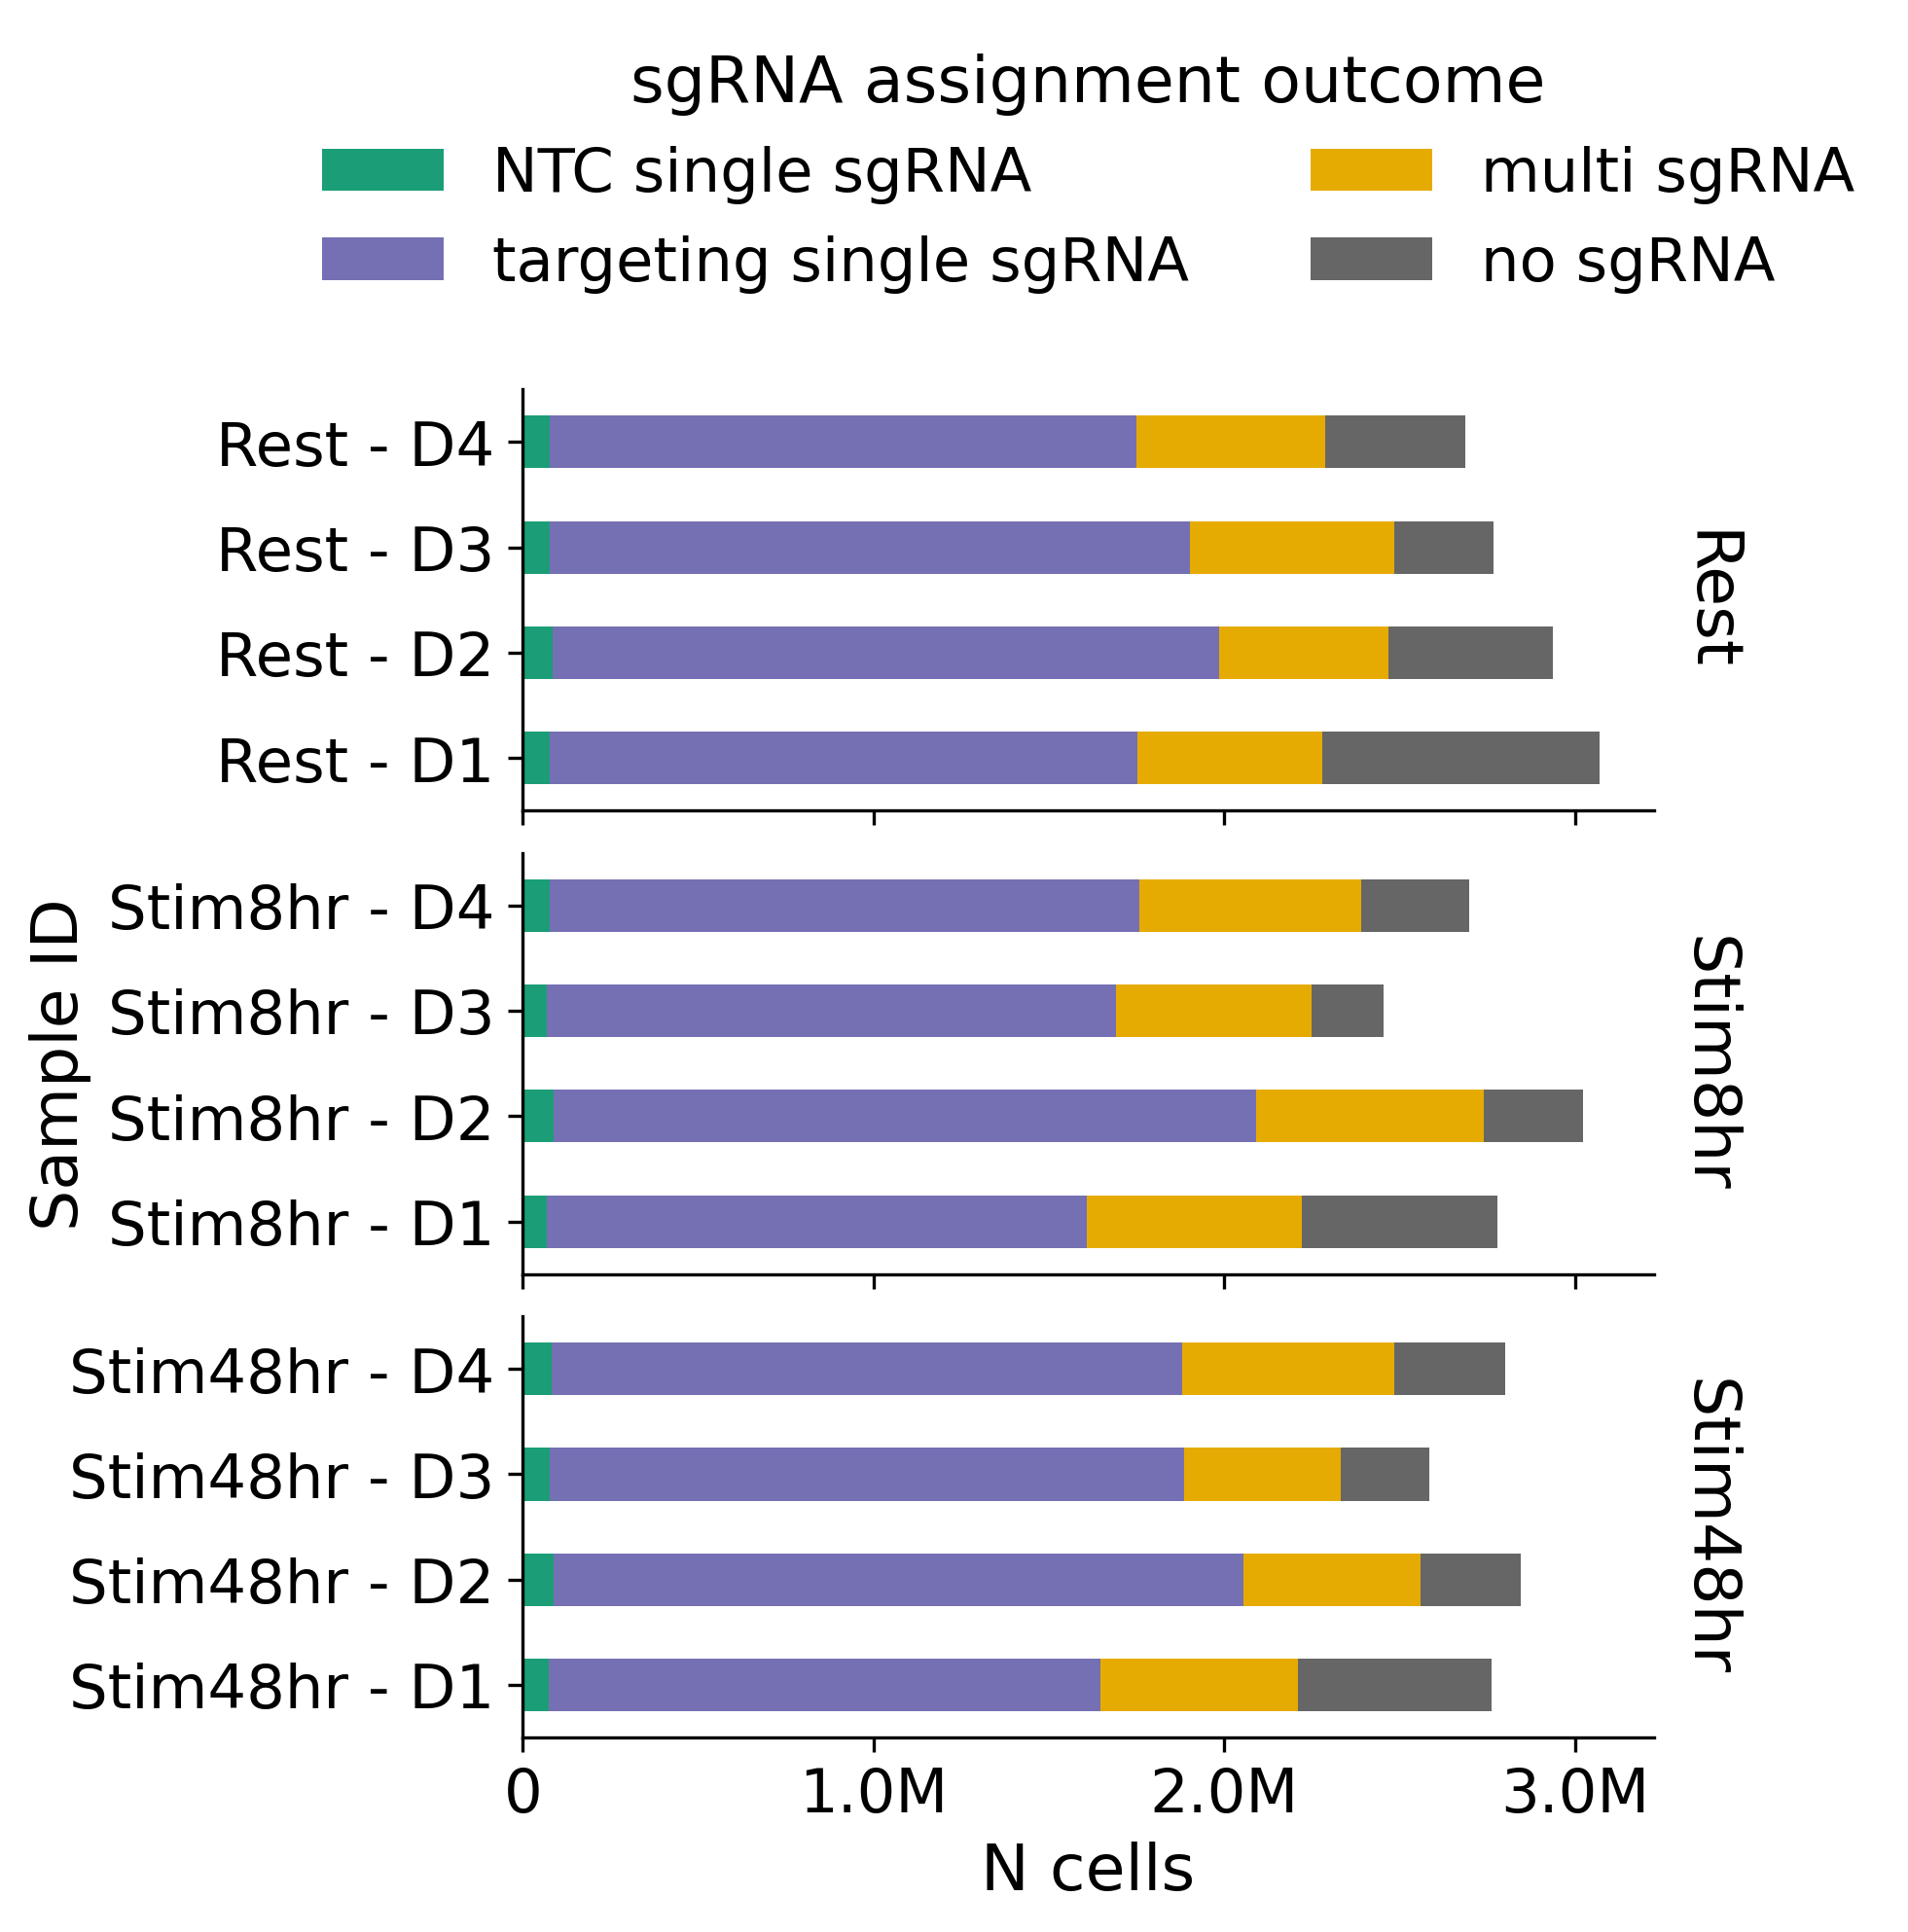

In [50]:
all_qc_summary['sample_id'] = all_qc_summary['culture_condition'].astype(str) + ' - ' + all_qc_summary['donor_id'].astype(str)
pl_df = all_qc_summary.groupby('sample_id').sum()
# Define the order for the groups
group_order = ['NTC single sgRNA', 'targeting single sgRNA', 'multi sgRNA', 'no sgRNA (>= 3 UMIs)']
# Create subplots for each culture condition
conditions = ['Rest', 'Stim8hr', 'Stim48hr']
fig, axes = plt.subplots(len(conditions), 1, figsize=(5, 6), sharex=True, gridspec_kw={'hspace': 0.1})


guide_group_colors = plt.cm.Dark2(np.linspace(0, 1, len(group_order)))

for idx, condition in enumerate(conditions):
    # Filter data for this condition
    condition_samples = [col for col in pl_df.index if condition in col]
    condition_data = pl_df.loc[condition_samples][group_order]
    condition_data = condition_data.rename({'no sgRNA (>= 3 UMIs)':'no sgRNA'}, axis=1)
    
    # Create stacked bar plot
    condition_data.plot(kind='barh', stacked=True, ax=axes[idx], color=guide_group_colors)
    axes[idx].annotate(condition, xy=(1.02, 0.5), xycoords='axes fraction', rotation=270, va='center')
    axes[idx].set_yticklabels(axes[idx].get_yticklabels(), ha='right')
    axes[idx].set_ylabel('Sample ID')
    # Format x-axis to use M notation for millions
    axes[idx].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M' if x >= 1e6 else f'{int(x/1e3)}K' if x >= 1e3 else int(x)))
    if idx != 0:
        axes[idx].get_legend().remove()
        axes[idx].set_xlabel('')
        if idx != 1:
            axes[idx].set_ylabel('')
    else:
        axes[idx].legend(bbox_to_anchor=(0.5, 1.1), loc='lower center',
                        title='sgRNA assignment outcome', frameon=False, ncol=2)
        axes[idx].set_ylabel('')
    if idx == 2:
        axes[idx].set_xlabel('N cells')
    # Remove spines 
    sns.despine(ax=axes[idx])

plt.tight_layout()
plt.savefig(PLOTDIR + "N_cells_assignment.png", bbox_inches='tight')
plt.savefig(PLOTDIR + "N_cells_assignment.pdf", bbox_inches='tight')

In [34]:
all_qc_summary.groupby('sample_id')[['NTC single sgRNA', 'targeting single sgRNA']].sum().sum(axis=1)

sample_id
Rest - D1        1752037
Rest - D2        1983457
Rest - D3        1901710
Rest - D4        1749091
Stim8hr - D1     1606762
Stim8hr - D2     2088831
Stim8hr - D3     1691862
Stim8hr - D4     1756364
Stim48hr - D1    1647835
Stim48hr - D2    2053058
Stim48hr - D3    1886233
Stim48hr - D4    1879602
dtype: int64

In [40]:
all_qc_summary.groupby('sample_id')[['NTC single sgRNA','multi sgRNA','no sgRNA (>= 3 UMIs)', 'targeting single sgRNA']].sum()

,NTC single sgRNA,multi sgRNA,no sgRNA (>= 3 UMIs),targeting single sgRNA
sample_id,,,,
Rest - D1,76543,525722,792766,1675494
Rest - D2,83987,485266,468145,1899470
Rest - D3,76823,581595,284410,1824887
Rest - D4,76636,538629,398537,1672455
Stim8hr - D1,69632,612957,557298,1537130
Stim8hr - D2,88354,649848,283620,2000477
Stim8hr - D3,68441,556629,204498,1623421
Stim8hr - D4,77030,633833,306036,1679334
Stim48hr - D1,73534,561781,550915,1574301


In [ ]:
from tkinter.constants import X

total_cells = all_qc_summary.groupby('sample_id')[['NTC single sgRNA','multi sgRNA','no sgRNA (>= 3 UMIs)', 'targeting single sgRNA']].sum().sum(axis=1).sum()
total_targeting_cells = all_qc_summary.groupby('sample_id')[['NTC single sgRNA', 'targeting single sgRNA']].sum().sum(axis=1).sum()
total_noguide_cells = all_qc_summary.groupby('sample_id')[['no sgRNA (>= 3 UMIs)']].sum().sum(axis=1).sum()
total_multiguide_cells = all_qc_summary.groupby('sample_id')[['multi sgRNA']].sum().sum(axis=1).sum()

# Print number and fraction of each cell class
print(f"Total cells: {total_cells}")
print(f"Targeting cells: {total_targeting_cells} ({total_targeting_cells/total_cells*100:.2f}%)")
print(f"No guide cells: {total_noguide_cells} ({total_noguide_cells/total_cells*100:.2f}%)")
print(f"Multi-guide cells: {total_multiguide_cells} ({total_multiguide_cells/total_cells*100:.2f}%)")

Total cells: 33400039
Targeting cells: 21996842 (65.86%)
No guide cells: 4698273 (14.07%)
Multi-guide cells: 6704924 (20.07%)


In [ ]:
total_targeting_cells = all_qc_summary.groupby('sample_id')[['NTC single sgRNA', 'targeting single sgRNA']].sum().sum(axis=1).sum()/

np.int64(21996842)

## Number of cells per perturbation

In [8]:
# Download and read the Core Essential and non-essential gene list (as used in GeneBayes paper)
ceg_url = "https://raw.githubusercontent.com/macarthur-lab/gene_lists/master/lists/CEGv2_subset_universe.tsv"
neg_url = 'https://raw.githubusercontent.com/macarthur-lab/gene_lists/refs/heads/master/lists/NEGv1_subset_universe.tsv'
core_essential = pd.read_csv(ceg_url, sep='\t', header=None)[0].tolist()
core_nonessential = pd.read_csv(neg_url, sep='\t', header=None)[0].tolist()

## Load IL2 hits
schmidt_crispri = pd.read_excel('../../metadata/Schmidt2022_hits_Supplementary_table_2.xlsx', usecols=range(10))
schmidt_crispri_hits = schmidt_crispri[schmidt_crispri['Hit'] & (schmidt_crispri['CRISPRa_or_i'] == 'CRISPRi') & (schmidt_crispri['CD4_or_CD8'] == 'CD4')]

# Create dictionary where key is hit type and values are lists of genes
hit_type_dict = {}
for hit_type in schmidt_crispri_hits['Hit_Type'].unique():
    hit_type_dict[hit_type] = schmidt_crispri_hits[schmidt_crispri_hits['Hit_Type'] == hit_type]['Gene'].tolist()


In [9]:
all_count_perturbs.head()

,CD4i_R2_D1_Stim48hr_CD4i_R2_Ultima.CD4i_R2L25,CD4i_R2_D1_Stim48hr_CD4i_R2_Ultima.CD4i_R2L26,CD4i_R2_D1_Stim48hr_CD4i_R2_Ultima.CD4i_R2L27,CD4i_R2_D1_Stim48hr_CD4i_R2_Ultima.CD4i_R2L28,CD4i_R2_D1_Stim48hr_CD4i_R2_Ultima.CD4i_R2L29,CD4i_R2_D1_Stim48hr_CD4i_R2_Ultima.CD4i_R2L30,CD4i_R2_D1_Stim48hr_CD4i_R2_Ultima.CD4i_R2L31,CD4i_R2_D1_Stim48hr_CD4i_R2_Ultima.CD4i_R2L32,CD4i_R2_D1_Stim48hr_CD4i_R2_Ultima.CD4i_R2L33,CD4i_R2_D1_Stim48hr_CD4i_R2_Ultima.CD4i_R2L34,...,CD4i_R1_D2_Stim8hr_CD4i_R1_Ultima.CD4i_R1L14,CD4i_R1_D2_Stim8hr_CD4i_R1_Ultima.CD4i_R1L15,CD4i_R1_D2_Stim8hr_CD4i_R1_Ultima.CD4i_R1L16,CD4i_R1_D2_Stim8hr_CD4i_R1_Ultima.CD4i_R1L17,CD4i_R1_D2_Stim8hr_CD4i_R1_Ultima.CD4i_R1L18,CD4i_R1_D2_Stim8hr_CD4i_R1_Ultima.CD4i_R1L19,CD4i_R1_D2_Stim8hr_CD4i_R1_Ultima.CD4i_R1L20,CD4i_R1_D2_Stim8hr_CD4i_R1_Ultima.CD4i_R1L21,CD4i_R1_D2_Stim8hr_CD4i_R1_Ultima.CD4i_R1L22,CD4i_R1_D2_Stim8hr_CD4i_R1_Ultima.CD4i_R1L23
guide_id,,,,,,,,,,,,,,,,,,,,,
A1BG-1,0.0,0.0,4.0,3.0,0.0,2.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A1BG-2,8.0,8.0,6.0,10.0,5.0,6.0,7.0,7.0,4.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A2M-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A2M-2,1.0,0.0,0.0,2.0,0.0,0.0,1.0,2.0,1.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAAS-1,2.0,4.0,1.0,2.0,5.0,0.0,6.0,7.0,6.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
pl_df = all_count_perturbs.reset_index().melt(id_vars='guide_id', var_name='library_id', value_name='n_cells')
pl_df = pd.merge(
    sgrna_library_metadata[['sgrna_id', 'perturbed_gene_name']].rename({'sgrna_id':'guide_id'}, axis=1),
    pl_df
)
pl_df['sample_id'] = pl_df.library_id.str.split('.').str[0]
pl_df['culture_condition'] = pl_df['sample_id'].str.split('_').str[3]

n_cells_count_df = pl_df.groupby(['perturbed_gene_name','culture_condition'])['n_cells'].sum().reset_index()


In [11]:
n_cells_per_guide = pl_df.dropna().groupby(['guide_id'])[['n_cells']].sum().sort_values('n_cells')

In [12]:
23573 / sgrna_library_metadata.shape[0]

0.8643663831035494

In [13]:
sgrna_library_metadata['sgrna_id'].isin(n_cells_per_guide.index).value_counts()

sgrna_id
True     25956
False     1316
Name: count, dtype: int64

In [111]:
sum(n_cells_per_guide['n_cells'] > 50)

23573

In [14]:
n_cells_count_df.groupby('culture_condition')['n_cells'].mean()

culture_condition
Rest        580.045155
Stim48hr    586.361552
Stim8hr     561.003534
Name: n_cells, dtype: object

In [15]:
n_cells_count_df['Schmidt_hits'] = np.nan
n_cells_count_df['Schmidt_hits'] = np.where(n_cells_count_df.perturbed_gene_name.isin(hit_type_dict['Positive Hit']), 'IL2_pos_hit', n_cells_count_df['Schmidt_hits'])
n_cells_count_df['Schmidt_hits'] = np.where(n_cells_count_df.perturbed_gene_name.isin(hit_type_dict['Negative Hit']), 'IL2_neg_hit', n_cells_count_df['Schmidt_hits'])

n_cells_count_df['essential_genes'] = np.nan
n_cells_count_df['essential_genes'] = np.where(n_cells_count_df.perturbed_gene_name.isin(core_essential), 'gold standard essential', n_cells_count_df['essential_genes'])
n_cells_count_df['essential_genes'] = np.where(n_cells_count_df.perturbed_gene_name.isin(core_nonessential), 'gold standard non-essential', n_cells_count_df['essential_genes'])


In [43]:
condition_all['essential_genes'].value_counts()

essential_genes
False    11935
True       798
Name: count, dtype: int64

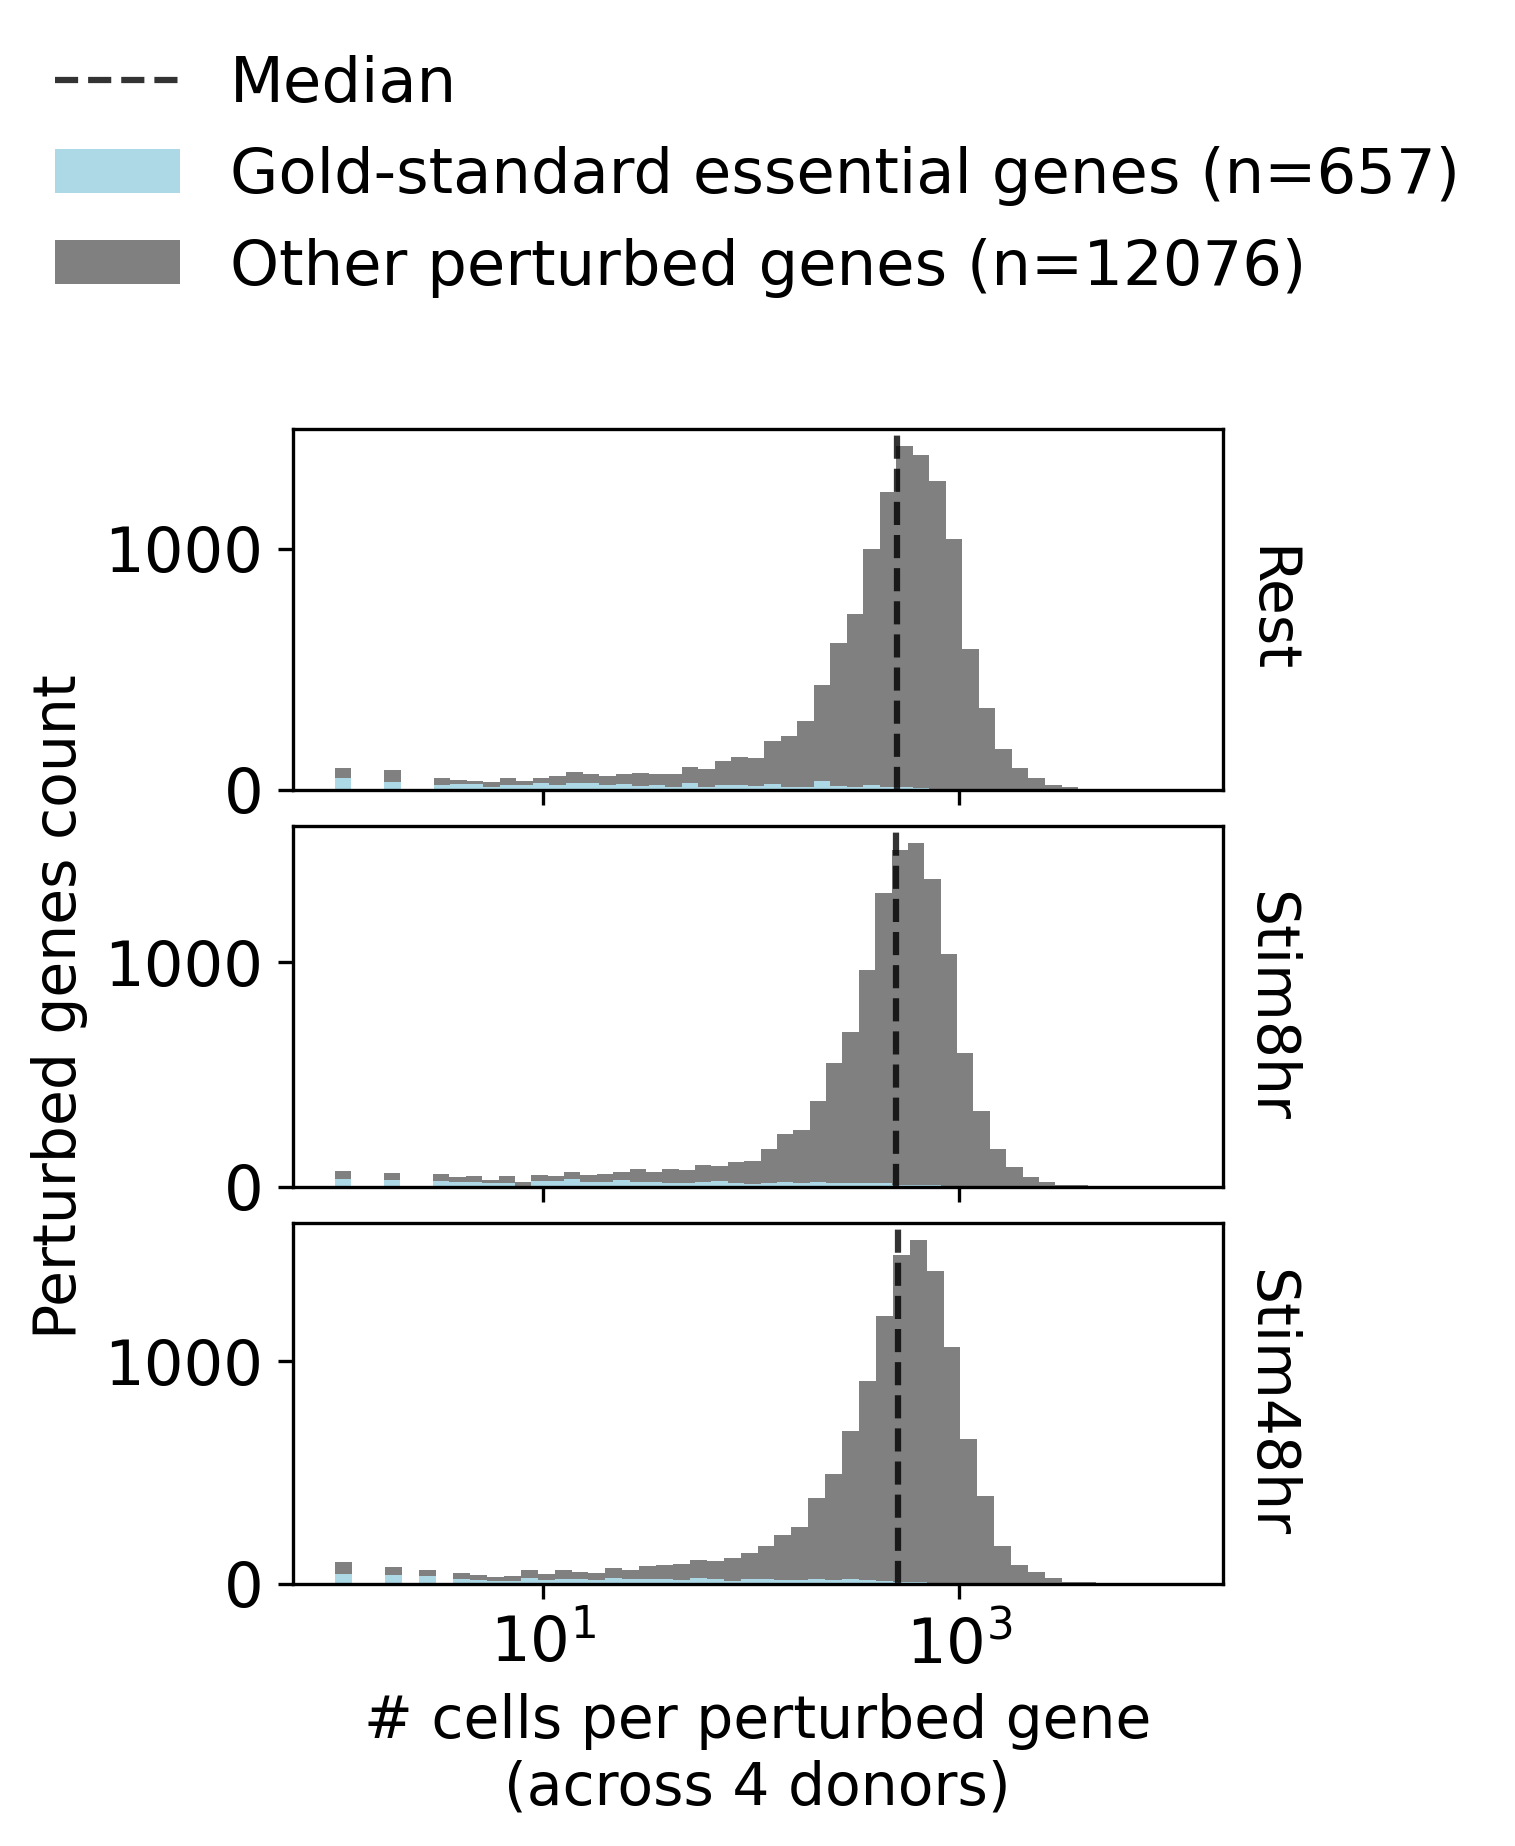

In [62]:
# Create histogram with density lines comparing IL2_neg_hit genes and essential genes with all genes
essential_df = n_cells_count_df[n_cells_count_df['essential_genes'] == 'gold standard essential']
all_genes_df = n_cells_count_df[n_cells_count_df.perturbed_gene_name != 'NTC']  # All genes except NTC

# Get unique conditions
conditions = ['Rest', 'Stim8hr', 'Stim48hr']
n_conditions = len(conditions)

# Create figure with subplots - one per condition
fig, axes = plt.subplots(len(conditions), 1, figsize=(4, 5), sharex=True, gridspec_kw={'hspace': 0.1})

# Plot for each condition
for i, condition in enumerate(conditions):
    condition_all = all_genes_df[all_genes_df['culture_condition'] == condition]
    
    # Create boolean mask for essential vs non-essential
    condition_all['is_essential'] = condition_all['essential_genes'] == 'gold standard essential'
    
    # Get unique gene counts for legend
    n_essential = len(condition_all[condition_all['is_essential']]['perturbed_gene_name'].unique())
    n_nonessential = len(condition_all[~condition_all['is_essential']]['perturbed_gene_name'].unique())
    # Plot histogram with essential/non-essential coloring
    sns.histplot(data=condition_all, x='n_cells', bins=50,
                hue='is_essential', log_scale=True,
                palette={True: 'lightblue', False: 'grey'},  # Red for essential, Blue for non-essential
                alpha=1, ax=axes[i],
                hue_order=[False, True],
                multiple="stack",
                edgecolor='none')

    # Calculate median excluding NaN values
    median_val = condition_all['n_cells'].median()
    
    # Add vertical line for median
    axes[i].axvline(x=median_val, color='black', alpha=0.8, linestyle='--',
                    label=f'Median: {median_val:.1f} cells')

    # Add rotated title on right side
    axes[i].text(1.02, 0.5, condition, rotation=-90, transform=axes[i].transAxes,
                va='center', ha='left', fontsize=14)

    # Customize legend
    if i == 0:
        axes[i].legend(title='',
                      labels=[
                        'Median',
                        f'Gold-standard essential genes (n={n_essential})', 
                        f'Other perturbed genes (n={n_nonessential})'
                             ],
                      bbox_to_anchor=(0.5, 1.7),
                      loc='center', frameon=False,
                      ncol=1)
    else:
        axes[i].get_legend().remove()
    
    if i != 1:
        axes[i].set_ylabel('', fontsize=14)
    else:
        axes[i].set_ylabel('Perturbed genes count', fontsize=14)
    if i == 2:
        axes[i].set_xlabel('# cells per perturbed gene\n(across 4 donors)', fontsize=14)
        axes[i].xaxis.set_major_locator(plt.LogLocator())
        axes[i].xaxis.set_minor_locator(plt.LogLocator(subs='all'))

plt.tight_layout()
plt.savefig(PLOTDIR + "N_cells_perturb.png", bbox_inches='tight')
plt.savefig(PLOTDIR + "N_cells_perturb.pdf", bbox_inches='tight')

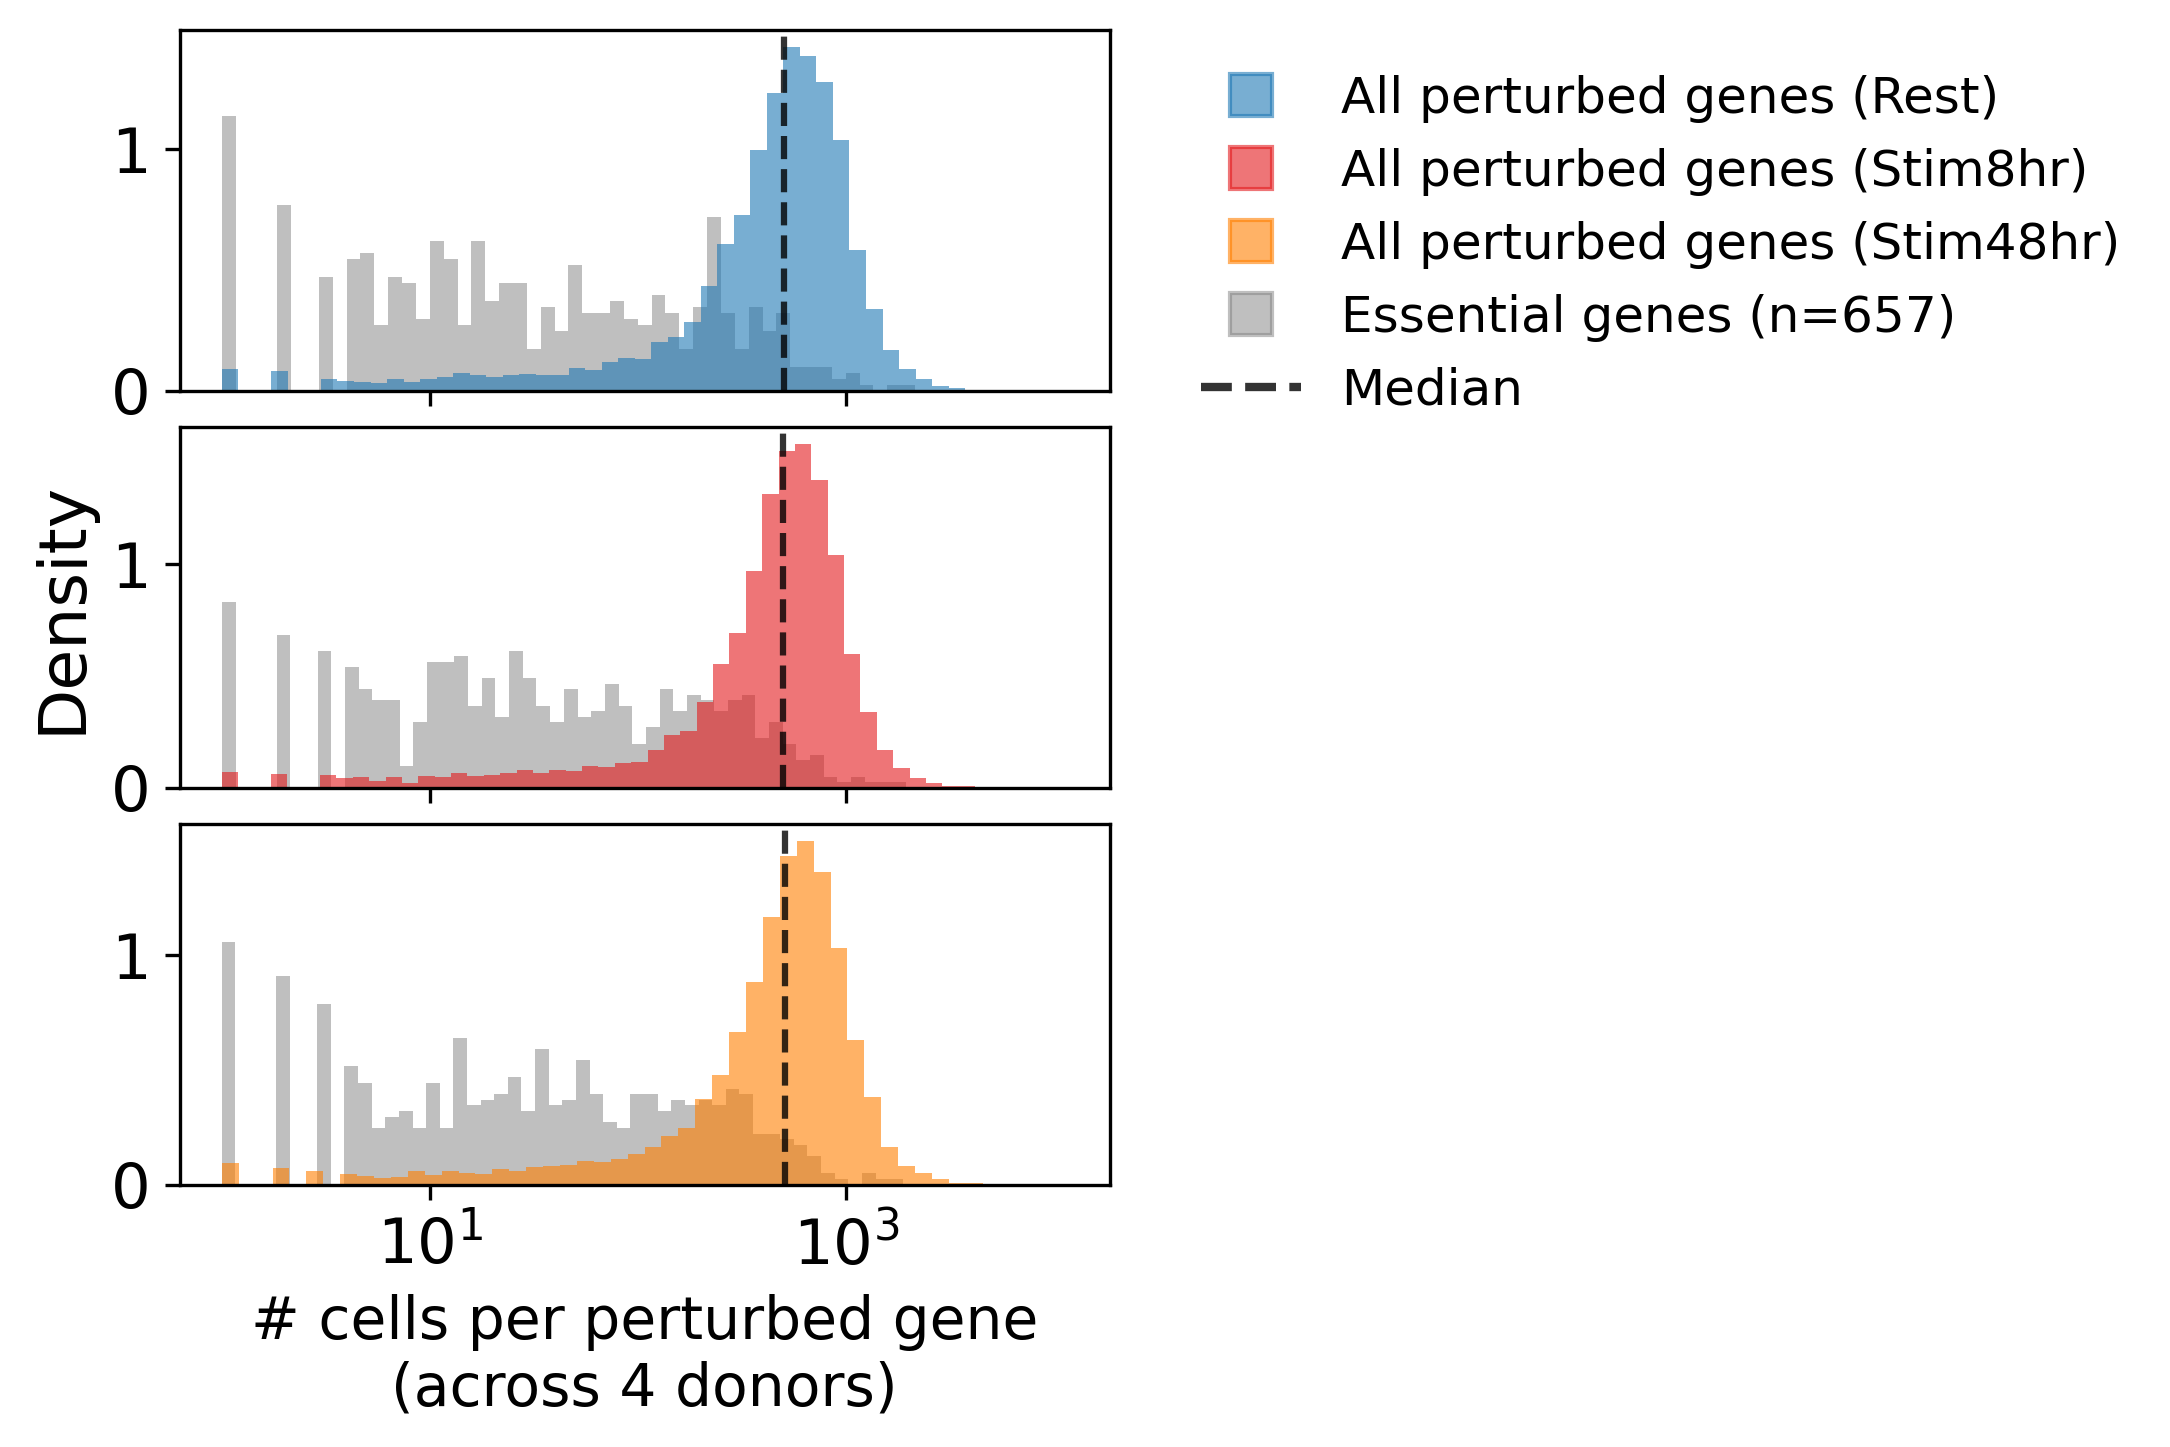

In [55]:
# Create histogram with density lines comparing IL2_neg_hit genes and essential genes with all genes
essential_df = n_cells_count_df[n_cells_count_df['essential_genes'] == 'gold standard essential']
all_genes_df = n_cells_count_df[n_cells_count_df.perturbed_gene_name != 'NTC']  # All genes except NTC

# Get unique conditions
conditions = ['Rest', 'Stim8hr', 'Stim48hr']
n_conditions = len(conditions)

# Create figure with subplots - one per condition
# fig, axes = plt.subplots(n_conditions,1, figsize=(8, 3*n_conditions), sharex=True)
fig, axes = plt.subplots(len(conditions), 1, figsize=(4, 5), sharex=True, gridspec_kw={'hspace': 0.1})
# Plot for each condition
for i, condition in enumerate(conditions):
    condition_all = all_genes_df[all_genes_df['culture_condition'] == condition]
    condition_essential = essential_df[essential_df['culture_condition'] == condition]

    # Get unique gene counts for legend
    n_all = len(condition_all['perturbed_gene_name'].unique())
    n_essential = len(condition_essential['perturbed_gene_name'].unique())

    # Plot histogram for essential genes in grey
    sns.histplot(data=condition_essential, x='n_cells', bins=50,
                stat='density', common_norm=False, log_scale=True,
                color='gray', alpha=0.5, ax=axes[i], label=f'Essential genes (n={n_essential})',
                edgecolor='none')

    # Plot histogram for all genes colored by condition
    sns.histplot(data=condition_all, x='n_cells', bins=50,
                stat='density', common_norm=False, log_scale=True,
                color=palettes['culture_condition'][condition], alpha=0.6, 
                label=f'All genes (n={n_all})', kde=True, ax=axes[i],
                edgecolor='none')

    # Add vertical line for median
    axes[i].axvline(x=condition_all['n_cells'].median(), color='black', alpha=0.8, linestyle='--',
                    label=f'Median: {condition_all["n_cells"].median():.1f} cells')

    
    # axes[i].text(0.05, 0.95, f'Culture condition: {condition}', fontsize=16, transform=axes[i].transAxes, va='top')
    if i == 0:  # Only show legend for first subplot
        # Create custom legend entries for each condition and essential genes
        from matplotlib.lines import Line2D
        legend_elements = [
            Line2D([0], [0], color=palettes['culture_condition']['Rest'], lw=0, marker='s', 
                  label='All perturbed genes (Rest)', markersize=10, alpha=0.6),
            Line2D([0], [0], color=palettes['culture_condition']['Stim8hr'], lw=0, marker='s',
                  label='All perturbed genes (Stim8hr)', markersize=10, alpha=0.6),
            Line2D([0], [0], color=palettes['culture_condition']['Stim48hr'], lw=0, marker='s',
                  label='All perturbed genes (Stim48hr)', markersize=10, alpha=0.6),
            Line2D([0], [0], color='gray', lw=0, marker='s',
                  label=f'Essential genes (n={n_essential})', markersize=10, alpha=0.5),
            Line2D([0], [0], color='black', lw=2, linestyle='--',
                  label='Median', alpha=0.8)
        ]
        axes[i].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), 
                      loc='upper left', fontsize=12, frameon=False)
    
    if i != 1:
        axes[i].set_ylabel('', fontsize=14)
    if i == 2:
        axes[i].set_xlabel('# cells per perturbed gene\n(across 4 donors)', fontsize=14)
        axes[i].xaxis.set_major_locator(plt.LogLocator())
        axes[i].xaxis.set_minor_locator(plt.LogLocator(subs='all'))
        

plt.tight_layout()
plt.savefig(PLOTDIR + "N_cells_perturb.png", bbox_inches='tight')
plt.savefig(PLOTDIR + "N_cells_perturb.pdf", bbox_inches='tight')

Total usable cells

In [56]:
n_cells_count_df['n_cells'].sum()

21996842.0

Check tail of distribution that are not in IL2 regulators or essential genes

In [57]:
n_cells_count_df[
    (n_cells_count_df.culture_condition == 'Rest') & 
    (n_cells_count_df['n_cells'] == 0) &
    (n_cells_count_df['Schmidt_hits'] == 'nan') &
    (n_cells_count_df['essential_genes'] == 'nan')
]['perturbed_gene_name'].tolist()

['AP2M1',
 'ATP6AP1',
 'ATRIP',
 'BTF3',
 'C12orf60',
 'CDAN1',
 'CDCA5',
 'CENPH',
 'CWC15',
 'CWC22',
 'EIF2B2',
 'GBF1',
 'GLE1',
 'HAUS6',
 'ISY1-RAB43',
 'LSM4',
 'LSM6',
 'MAT2A',
 'MZT1',
 'NCSTN',
 'NUP205',
 'PHAX',
 'PMF1',
 'RFC3',
 'RPS3A',
 'SCFD1',
 'SENP6',
 'SF3B4',
 'SNRPE',
 'SUPT16H',
 'TAF1A',
 'TBCE',
 'THAP1',
 'TIMELESS',
 'TOX4',
 'TREX2',
 'UBAP1',
 'ZNF511']

In [58]:
n_cells_count_df[
    (n_cells_count_df.culture_condition == 'Stim48hr') & 
    (n_cells_count_df['n_cells'] == 0) &
    (n_cells_count_df['Schmidt_hits'] == 'nan') &
    (n_cells_count_df['essential_genes'] == 'nan')
]['perturbed_gene_name'].tolist()

['ATP6V1C1',
 'BNIP1',
 'BRF1',
 'C5orf22',
 'DDX46',
 'EIF2B2',
 'GBF1',
 'GFPT1',
 'HSPA5',
 'KANSL2',
 'MAT2A',
 'MZT1',
 'NBPF12',
 'NCAPG',
 'PDCD11',
 'POLD2',
 'RPL7',
 'RPS9',
 'RRP7A',
 'SF3B4',
 'SF3B6',
 'SNRPE',
 'THAP1',
 'VPS51',
 'ZMAT2',
 'ZNF511']

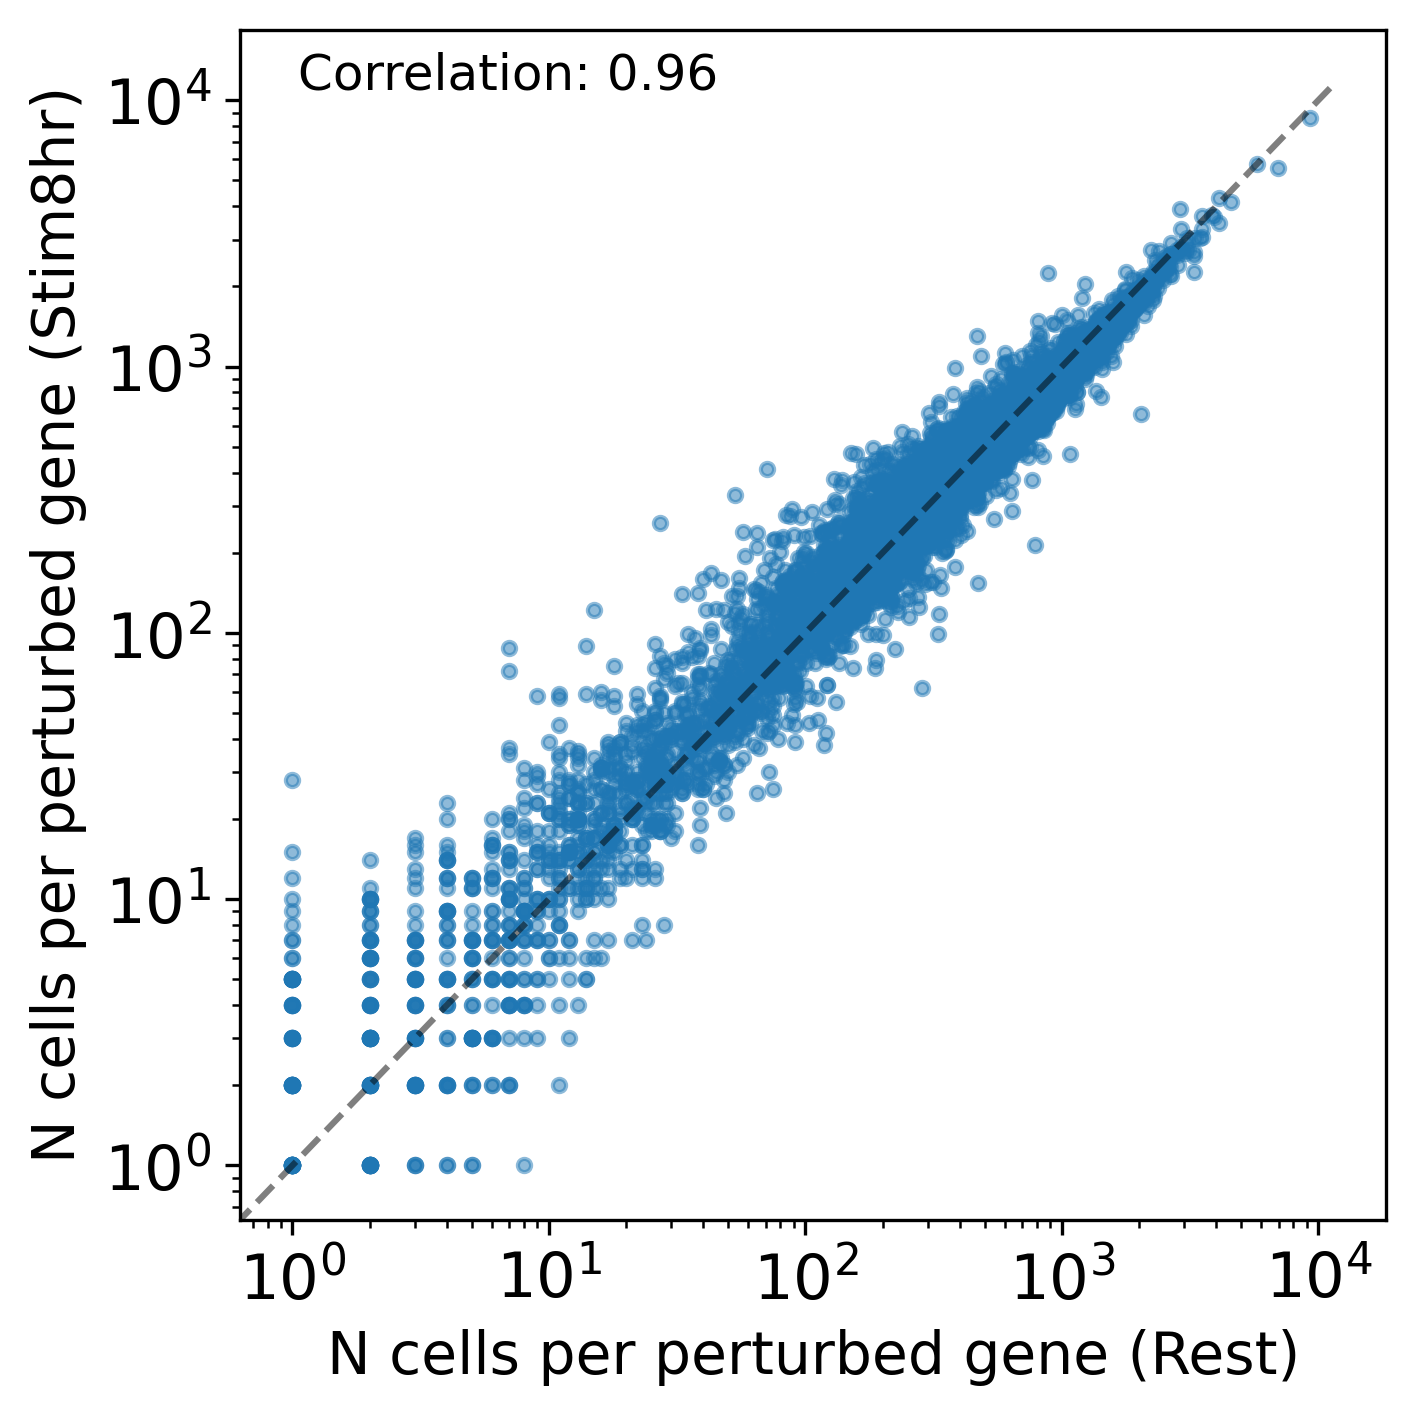

In [59]:
# Create a scatter plot comparing cell counts between conditions
plt.figure(figsize=(5, 5))
plt.scatter(all_genes_df[all_genes_df['culture_condition'] == 'Rest']['n_cells'],
           all_genes_df[all_genes_df['culture_condition'] == 'Stim8hr']['n_cells'],
           alpha=0.5, s=10)

# Add diagonal line
max_val = max(all_genes_df['n_cells'].max(), all_genes_df['n_cells'].max())
plt.plot([0, max_val], [0, max_val], 'k--', alpha=0.5)

plt.xlabel('N cells per perturbed gene (Rest)', fontsize=14)
plt.ylabel('N cells per perturbed gene (Stim8hr)', fontsize=14)

# Add correlation coefficient
corr = all_genes_df.pivot(columns='culture_condition', 
                         index='perturbed_gene_name', 
                         values='n_cells').corr().iloc[0,1]
plt.text(0.05, 0.95, f'Correlation: {corr:.2f}', 
         transform=plt.gca().transAxes, fontsize=12)
plt.xscale('log')
plt.yscale('log')

plt.tight_layout()

## Comparison to other perturb-seq datasets

In [60]:
tahoe_stats = pd.read_csv('../../metadata/Tahoe100M_cellline_stats.csv', index_col=0)
tahoe_stats['dataset'] = 'Tahoe-100M'

# Stats from the papers 
tahoe_stats.loc[len(tahoe_stats)] = {'cell_line': 'K562', 'median_n_cells_x_perturb': 166, 'median_tscp_count': 11499, 'dataset': 'Replogle 2022'}
tahoe_stats.loc[len(tahoe_stats)] = {'cell_line': 'HCT116', 'median_n_cells_x_perturb': 141, 'median_tscp_count': 19416, 'dataset': 'Xaira'}
tahoe_stats.loc[len(tahoe_stats)] = {'cell_line': 'HEK293T', 'median_n_cells_x_perturb': 188, 'median_tscp_count': 16557, 'dataset': 'Xaira'}
tahoe_stats.loc[len(tahoe_stats)] = {'cell_line': 'iPSC', 'median_n_cells_x_perturb': 250, 'median_tscp_count': 5000, 'dataset': 'Nourredine 2024'}



In [61]:
n_cells_count_df['perturbed_gene_name'].nunique()

12734

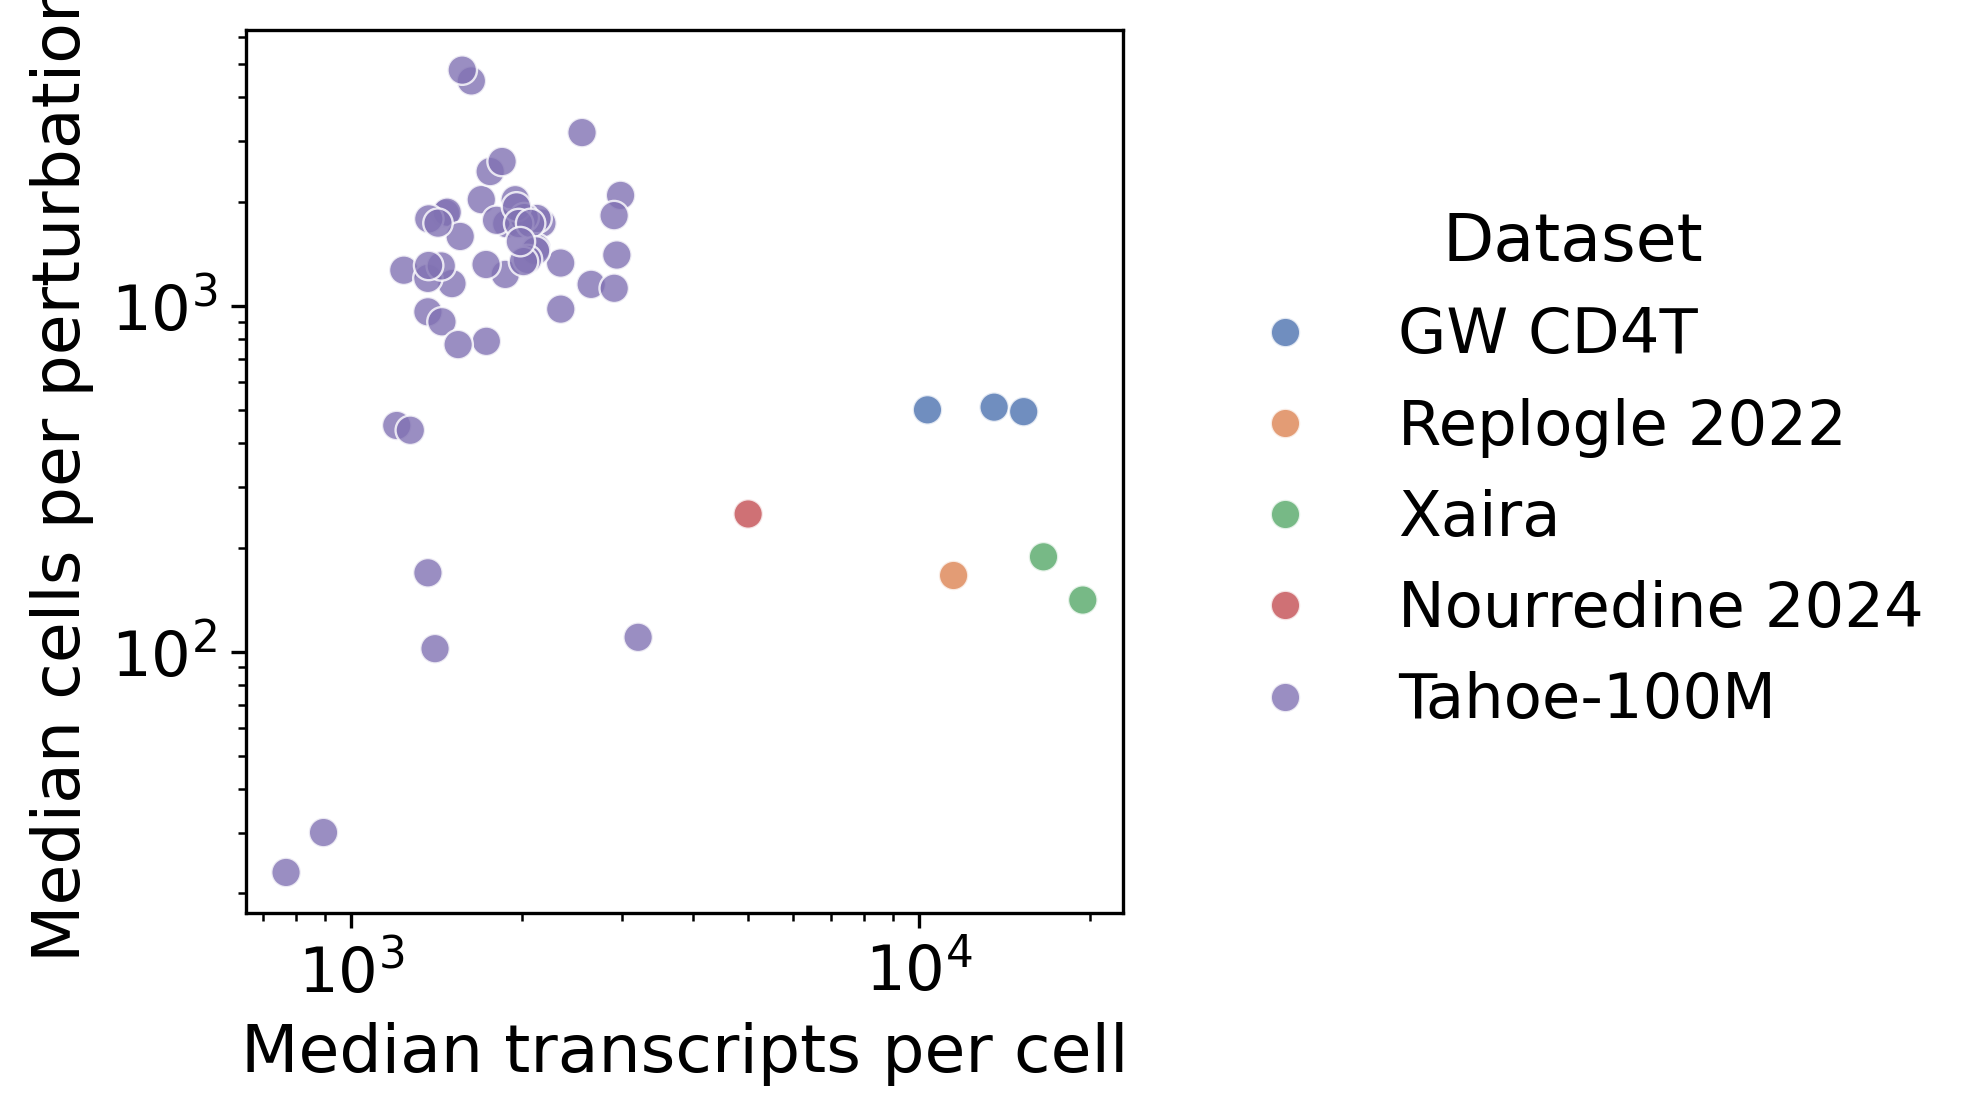

In [62]:
# Stats from this dataset
median_tscp_counts_study = all_qc_summary.groupby('culture_condition')['mean_total_counts'].median().reset_index()
median_n_cells_x_perturb_study = n_cells_count_df.groupby('culture_condition')['n_cells'].median().reset_index()
this_dataset_stats = pd.merge(median_n_cells_x_perturb_study, median_tscp_counts_study).rename({
    'culture_condition':'cell_line',
    'n_cells':'median_n_cells_x_perturb',
    'mean_total_counts':'median_tscp_count',
}, axis=1)
this_dataset_stats['dataset'] = 'GW CD4T'
all_dataset_stats = pd.concat([this_dataset_stats, tahoe_stats])

# Create single scatter plot
plt.figure(figsize=(7,4))
g = sns.scatterplot(data=all_dataset_stats, 
                    x='median_tscp_count', 
                    y='median_n_cells_x_perturb', 
                    hue='dataset',
                    hue_order=['GW CD4T', 'Replogle 2022', 'Xaira', 'Nourredine 2024', 'Tahoe-100M'],
                    alpha=0.8, s=50,
                    palette='deep')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Median transcripts per cell')
plt.ylabel('Median cells per perturbation')

# Add legend to the right
plt.legend(title='Dataset', 
          loc='center left',
          bbox_to_anchor=(1.05, 0.5),
          ncol=1,
          frameon=False)

plt.tight_layout()

plt.savefig(PLOTDIR + "perturbseq_comparison.png", bbox_inches='tight')
plt.savefig(PLOTDIR + "perturbseq_comparison.pdf", bbox_inches='tight')

## Mean counts in multi guides

In [8]:
exp_names = ['CD4iR1_Psomagen', 'CD4iR2_Psomagen']
files = []

for exp_name in exp_names:
    exp_config = config[exp_name]
    datadir = _convert_oak_path(exp_config['datadir'])
    sample_metadata_csv = _convert_oak_path(exp_config['sample_metadata'])

    # Get guide group stats files for this experiment
    exp_files = glob.glob(f'{datadir}/tmp/*.guide_group_stats.csv')
    files.extend(exp_files)

sgrna_library_metadata = pd.read_csv('../../metadata/sgRNA_library_curated.csv', index_col=0)
guide_type_qc_list = []
for f in files:
    sample_id = '.'.join(f.split("/")[-1].split('.')[0:2])
    sample_qc = pd.read_csv(f, index_col=0)
    guide_type_qc_list.append(sample_qc)

guide_type_qc = pd.concat(guide_type_qc_list, ignore_index=True)

In [9]:
guide_type_qc['condition'] = guide_type_qc['sample_id'].str.split('.').str[0].str.split('_').str[3]
guide_type_qc['experiment'] = guide_type_qc['sample_id'].str.split('.').str[0].str.split('_').str[1]
guide_type_qc.head()


,guide_group,metric,mean,sem,sample_id,condition,experiment
0,multi sgRNA,total_counts,25918.156250,147.214218,CD4i_R1_D1_Stim8hr_CD4i_R1_Ultima.CD4i_R1L07,Stim8hr,R1
1,no sgRNA,total_counts,11850.669922,42.536087,CD4i_R1_D1_Stim8hr_CD4i_R1_Ultima.CD4i_R1L07,Stim8hr,R1
2,targeting single sgRNA,total_counts,12292.168945,26.216311,CD4i_R1_D1_Stim8hr_CD4i_R1_Ultima.CD4i_R1L07,Stim8hr,R1
3,multi sgRNA,n_genes,5499.729206,9.746117,CD4i_R1_D1_Stim8hr_CD4i_R1_Ultima.CD4i_R1L07,Stim8hr,R1
4,no sgRNA,n_genes,4210.250782,8.205887,CD4i_R1_D1_Stim8hr_CD4i_R1_Ultima.CD4i_R1L07,Stim8hr,R1


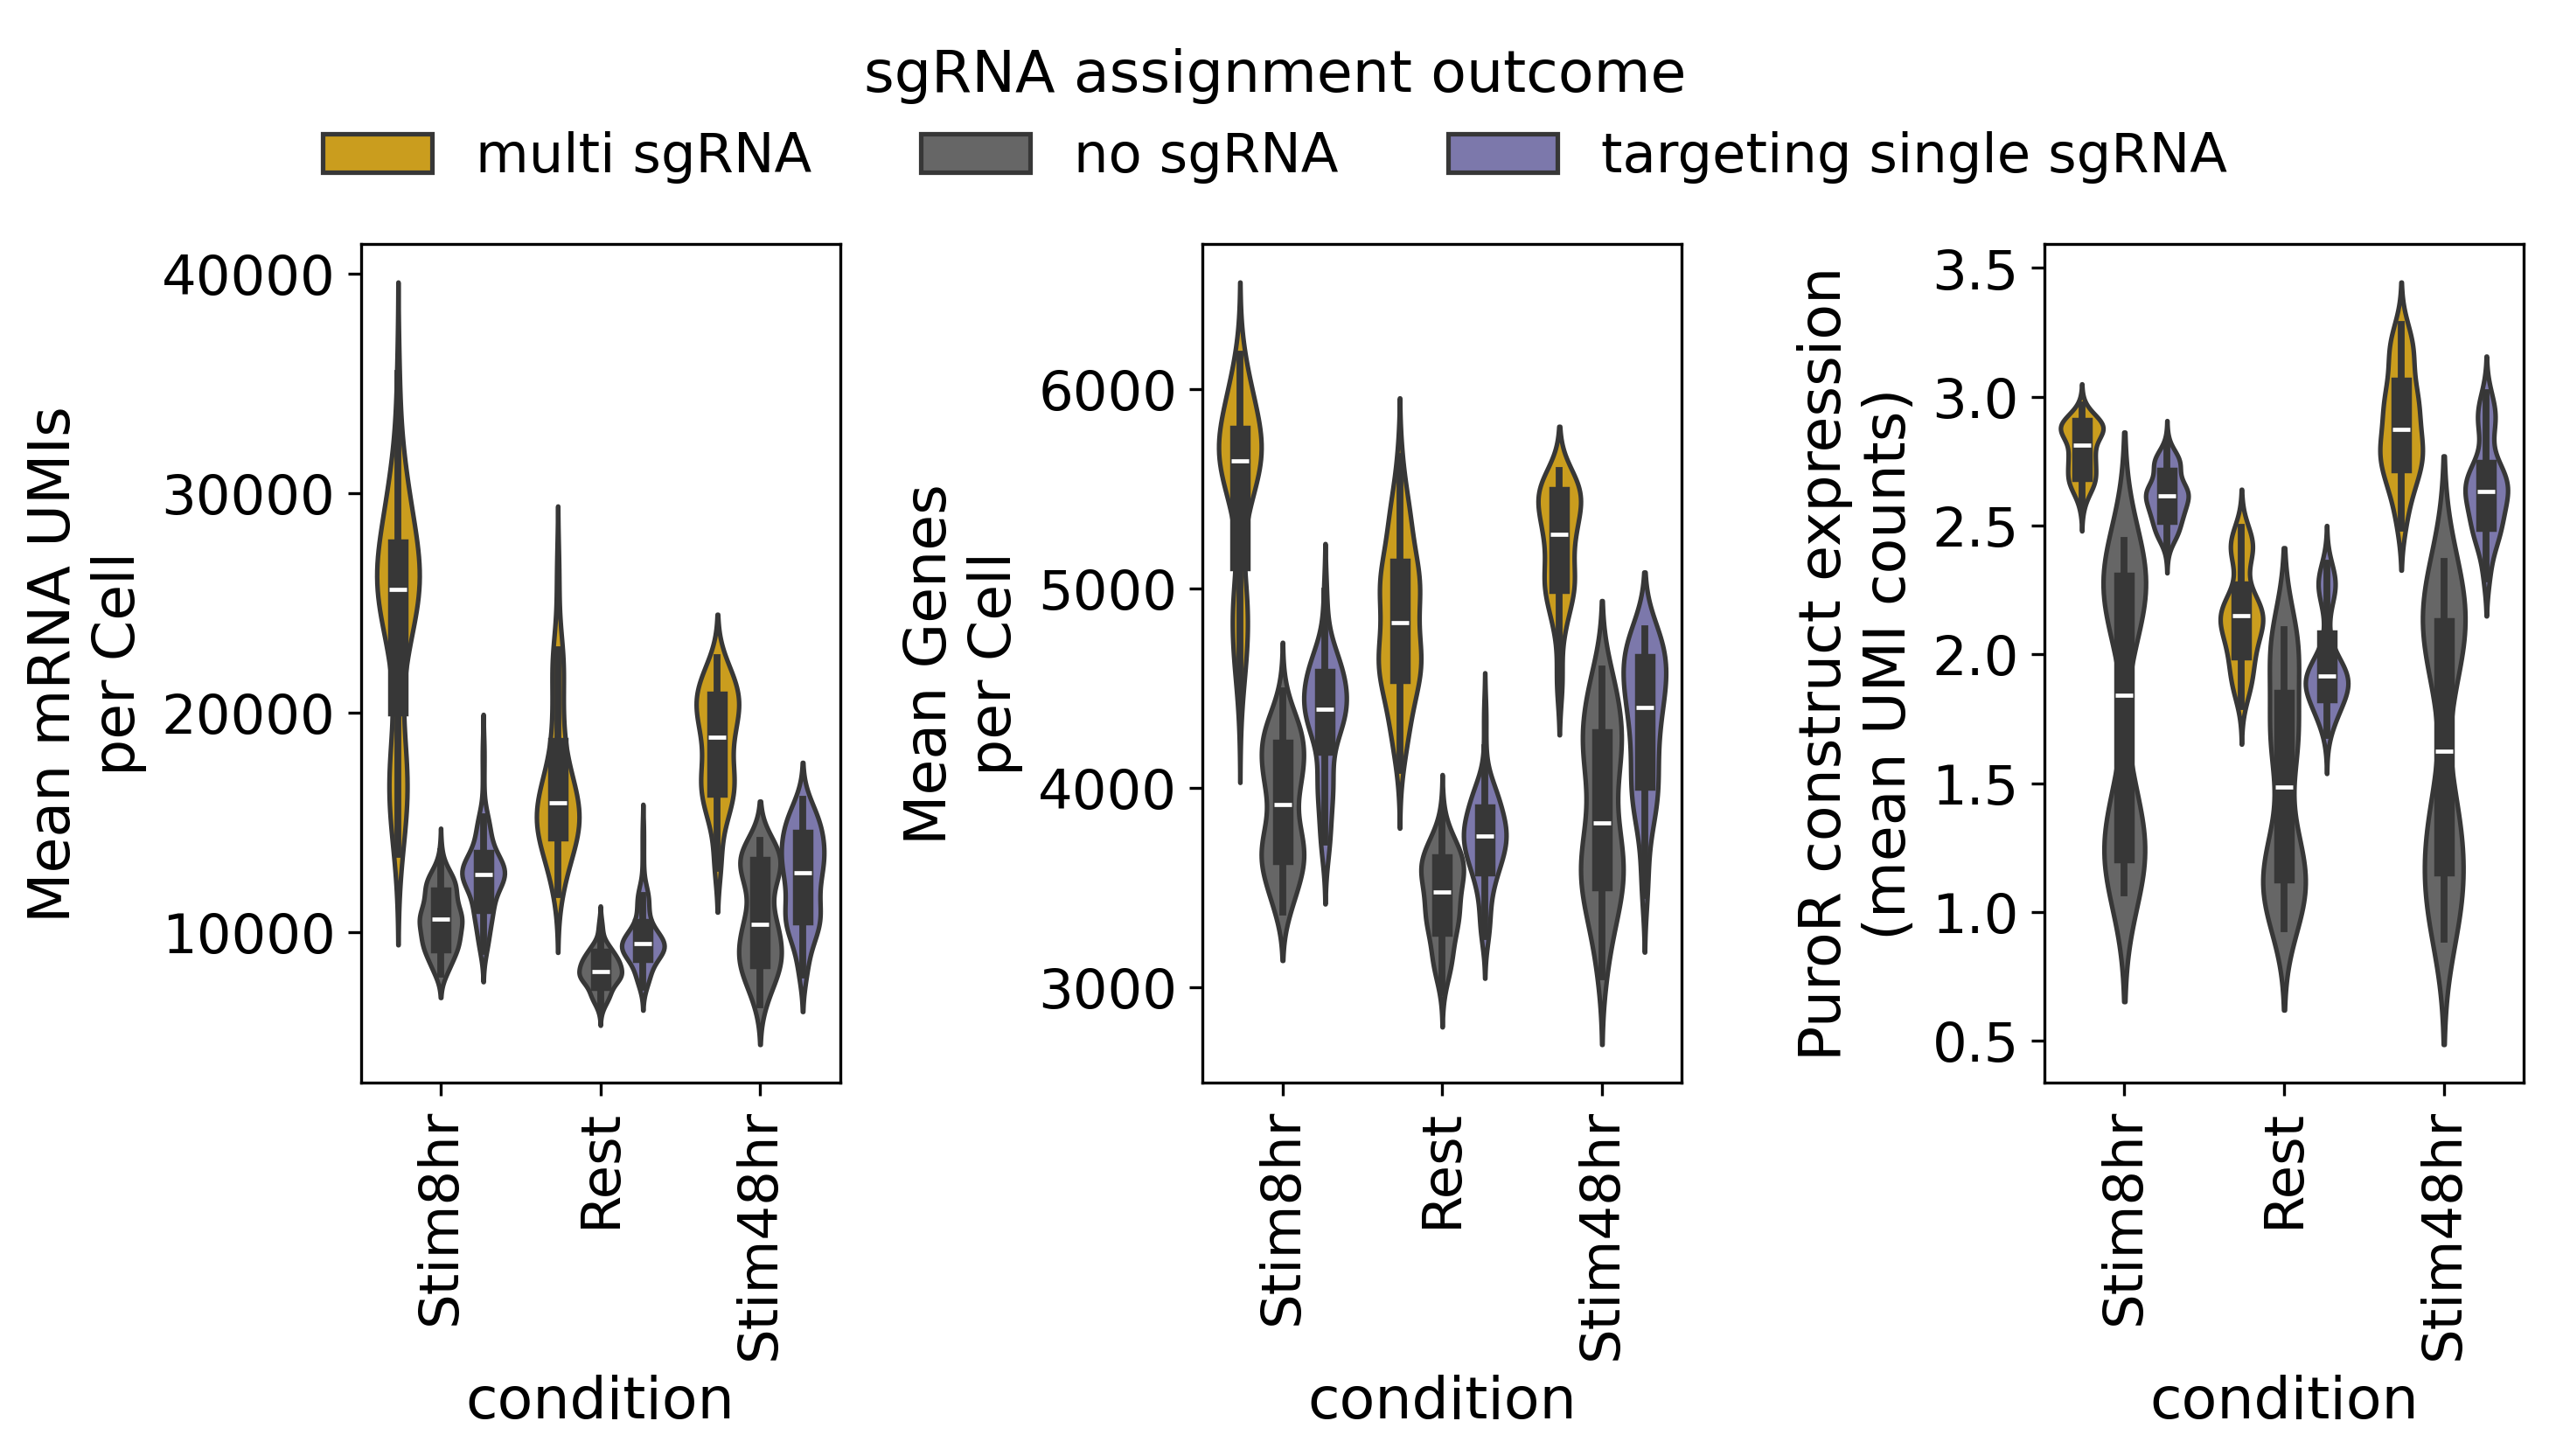

In [65]:
group_colors = dict(zip(['NTC single sgRNA', 'targeting single sgRNA', 'multi sgRNA', 'no sgRNA'], guide_group_colors))

# Create a subplot for each unique metric
metrics = guide_type_qc['metric'].unique()
metrics_labels = {
    'total_counts': 'Mean mRNA UMIs\nper Cell',  
    'n_genes': 'Mean Genes\nper Cell',  
    'PuroR': 'PuroR construct expression\n(mean UMI counts)',  
}
fig, axes = plt.subplots(1, len(metrics), figsize=(10, 5))

# Create first plot with legend
metric_data = guide_type_qc[guide_type_qc['metric'] == metrics[0]]
sns.violinplot(data=metric_data, x='condition', hue='guide_group', y='mean', ax=axes[0], palette=group_colors, legend=True, scale='width')
axes[0].set_ylabel(metrics_labels[metrics[0]])
axes[0].tick_params(axis='x', rotation=90)
legend = axes[0].get_legend()
legend.remove()

# Create remaining plots without legend
for i, metric in enumerate(metrics[1:], 1):
    metric_data = guide_type_qc[guide_type_qc['metric'] == metric]
    sns.violinplot(data=metric_data, x='condition', hue='guide_group', y='mean', ax=axes[i], palette=group_colors, legend=False, scale='width')
    # sns.stripplot(data=metric_data, x='condition', hue='guide_group', y='mean', ax=axes[i], size=3, alpha=0.3, dodge=True, legend=False, color='black')
    axes[i].set_ylabel(metrics_labels[metric])
    axes[i].tick_params(axis='x', rotation=90)

# Place legend at the top of the figure
fig.legend(bbox_to_anchor=(0.5, 1.05), loc='center', ncol=4, title='sgRNA assignment outcome', frameon=False)
plt.tight_layout()

plt.savefig(PLOTDIR + 'guide_group_stats.pdf', bbox_inches='tight')
plt.savefig(PLOTDIR + 'guide_group_stats.png', bbox_inches='tight')

In [17]:
guide_type_qc[(guide_type_qc['metric'] == 'total_counts') & (guide_type_qc['guide_group'] == 'targeting single sgRNA')]['mean'].median()

np.float64(11513.25927734375)

In [26]:
guide_type_qc[(guide_type_qc['metric'] == 'n_genes') & (guide_type_qc['guide_group'] == 'targeting single sgRNA')].groupby(['condition'])['mean'].mean()

condition
Rest        3737.422007
Stim48hr    4318.356425
Stim8hr     4342.661471
Name: mean, dtype: float64

In [22]:
all_qc_summary

,library_id,lane_id,mean_total_counts,mean_n_genes,mean_pct_counts_mt,mean_top_guide_UMI_counts,n_cells,n_low_quality_cells,NTC single sgRNA,multi sgRNA,no sgRNA (>= 3 UMIs),targeting single sgRNA,n_unique_guides,n_unique_perturbed_genes,mean_cells_x_guide,mean_cells_x_perturbed_gene,experiment
0,CD4i_R2_D3_Rest_CD4i_R2_Ultima,CD4i_R2L01,13285.634,4187.814500,0.573849,150.328896,113914,443,3219,23860,11295,75097,14076,9634,5.563797,8.129126,CD4iR2_Psomagen
0,CD4i_R2_D3_Rest_CD4i_R2_Ultima,CD4i_R2L02,16580.342,4556.615607,0.599576,141.191995,88433,409,2446,17097,10388,58093,12508,8882,4.840022,6.815920,CD4iR2_Psomagen
0,CD4i_R2_D3_Rest_CD4i_R2_Ultima,CD4i_R2L03,13797.838,4212.409915,0.592349,143.489722,89504,397,2457,16912,10338,59400,12608,8951,4.906171,6.910625,CD4iR2_Psomagen
0,CD4i_R2_D3_Rest_CD4i_R2_Ultima,CD4i_R2L04,15891.131,4525.213117,0.584216,146.301763,88740,452,2381,17277,10218,58412,12691,8984,4.790245,6.766808,CD4iR2_Psomagen
0,CD4i_R2_D3_Rest_CD4i_R2_Ultima,CD4i_R2L05,15209.561,4435.575832,0.579576,150.594691,107521,490,3000,23255,10664,70112,13801,9511,5.297587,7.687099,CD4iR2_Psomagen
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,CD4i_R1_D2_Stim8hr_CD4i_R1_Ultima,CD4i_R1L20,14917.503,4707.129863,0.681839,96.128412,133225,477,3886,28576,11967,88319,15836,10292,5.822493,8.958900,CD4iR1_Psomagen
0,CD4i_R1_D2_Stim8hr_CD4i_R1_Ultima,CD4i_R1L21,15692.449,4802.551268,0.684196,96.135906,132208,447,3846,28820,11828,87267,15780,10252,5.773954,8.887339,CD4iR1_Psomagen
0,CD4i_R1_D2_Stim8hr_CD4i_R1_Ultima,CD4i_R1L22,14666.247,4673.689627,0.676616,94.388921,133752,465,3847,28762,12229,88449,15861,10304,5.819053,8.957298,CD4iR1_Psomagen
0,CD4i_R1_D2_Stim8hr_CD4i_R1_Ultima,CD4i_R1L12,15352.078,4776.967967,0.698361,95.354175,128150,433,3780,27502,12113,84322,15551,10199,5.665359,8.638298,CD4iR1_Psomagen


In [27]:
all_qc_summary.groupby('culture_condition')['mean_total_counts'].median()

culture_condition
Rest        10344.7670
Stim8hr     15279.2085
Stim48hr    13554.2320
Name: mean_total_counts, dtype: float64